# Lifting Tracker
Sync workout JSON files, compute metrics, and visualize progress toward fitness goals.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import glob
import os
from datetime import datetime

# === PLOT STYLING ===
plt.rcParams.update({
    # Font sizes
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "figure.titlesize": 18,
    # Bold fonts
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    # Thicker spines
    "axes.linewidth": 2,
    "xtick.major.width": 1.5,
    "ytick.major.width": 1.5,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    # Grid
    "axes.grid": True,
    "grid.alpha": 0.3,
})
sns.set_style("whitegrid")

DATA_DIR = "../data/"
EXCEL_FILE = "workout_log.xlsx"

In [27]:
# Movement Family Mapping (exact match, tried first)
FAMILY_MAP = {
    # Squat
    "Front Squat": "Squat", "Back Squat": "Squat", "Zercher Squat": "Squat",
    "Squat": "Squat", "Squats": "Squat", "Pause Squat": "Squat",
    # Hinge
    "Deadlift": "Hinge", "Zercher Deadlift": "Hinge", "Romanian Deadlift": "Hinge",
    "RDL": "Hinge", "Kettlebell Swings": "Hinge",
    # Horizontal Push
    "Barbell Bench Press": "Push (H)", "Bench Press": "Push (H)",
    "Incline BB Press": "Push (H)", "DB Press": "Push (H)",
    "Incline DB Press": "Push (H)", "Incline DB Fly": "Push (H)", "Incline DB Flys": "Push (H)",
    "Incline Dumbbell Press": "Push (H)", "Dumbbell Press": "Push (H)",
    "Dips": "Push (H)", "Assisted Dip": "Push (H)", "Assisted Dips": "Push (H)",
    "Dumbbell Pullover": "Push (H)", "Chest Fly": "Push (H)",
    # Vertical Push
    "Standing BTN Press": "Push (V)", "BTN Standing Press": "Push (V)",
    "Behind the Neck Press": "Push (V)", "Behind the Neck Standing Overhead Press": "Push (V)",
    "Standing OHP": "Push (V)", "Overhead Press": "Push (V)", "DB Shoulder Press": "Push (V)",
    "Standing Overhead Press": "Push (V)",
    # Horizontal Pull
    "Bent over Barbell Rows": "Pull (H)", "Bent over barbell row": "Pull (H)", "Cable Rows": "Pull (H)",
    "Bent Over Row": "Pull (H)", "Seated Cable Rows": "Pull (H)", "Seated Row": "Pull (H)",
    "Dumbbell Rows": "Pull (H)", "Rear Delt Fly": "Pull (H)",
    # Vertical Pull
    "Pull Ups": "Pull (V)", "Lat Pulldown": "Pull (V)",
    "Assisted Pullup": "Pull (V)", "Assisted Pullups": "Pull (V)",
    # Arms
    "Incline Bicep Curl": "Arms", "Barbell Bicep Curl": "Arms",
    "Cable Bicep Curl": "Arms", "Cable Tricep Pushdown": "Arms",
    "Bicep Curl": "Arms", "Bicep Curls": "Arms", "Dumbbell Curls": "Arms",
    "Overhead Tricep Ext": "Arms", "Tricep Extension": "Arms", "Tricep Pushdown": "Arms",
    # Core
    "Cable Crunches": "Core",
    # Cardio
    "Run": "Cardio"
}

# Keyword fallback (checked in order when exact match fails)
# More specific patterns must come before general ones
FAMILY_KEYWORDS = [
    ("Behind the Neck", "Push (V)"), ("BTN", "Push (V)"),
    ("OHP", "Push (V)"), ("Shoulder Press", "Push (V)"),
    ("Deadlift", "Hinge"), ("RDL", "Hinge"), ("Romanian", "Hinge"),
    ("Kettlebell", "Hinge"), ("Swing", "Hinge"),
    ("Squat", "Squat"),
    ("Bench", "Push (H)"), ("Chest Fly", "Push (H)"),
    ("Pullover", "Push (H)"), ("Dip", "Push (H)"),
    ("Rear Delt", "Pull (H)"), ("Row", "Pull (H)"),
    ("Pull Up", "Pull (V)"), ("Pullup", "Pull (V)"),
    ("Pulldown", "Pull (V)"), ("Lat Pull", "Pull (V)"),
    ("Overhead Press", "Push (V)"),
    ("Press", "Push (H)"), ("Fly", "Push (H)"),
    ("Curl", "Arms"), ("Bicep", "Arms"), ("Tricep", "Arms"),
    ("Crunch", "Core"), ("Ab ", "Core"),
    ("Run", "Cardio"), ("Cardio", "Cardio"),
]

def map_movement_to_family(movement):
    """Map a movement name to its family. Exact match first, then keyword fallback."""
    if movement in FAMILY_MAP:
        return FAMILY_MAP[movement]
    for keyword, family in FAMILY_KEYWORDS:
        if keyword.lower() in movement.lower():
            return family
    return "Other"

# 2026 Strength Milestones: (weight_kg, reps)
# Keys are search terms (case-insensitive partial match against Movement)
MILESTONES = {
    "Squat": [(160, 1), (100, 20)],
    "Deadlift": [(200, 1), (160, 5)],
    "Overhead Press": [(60, 3), (40, 12)],
    "Bench Press": [(100, 1), (60, 10)],
    "barbell row": [(80, 6), (60, 12)],
    "Kettlebell": [(24, 80)]
}

# Antagonistic pairings for session recommender
ANTAGONISTIC_PAIRS = {
    "Squat": "Push (V)", "Push (V)": "Squat",
    "Hinge": "Push (H)", "Push (H)": "Hinge",
    "Pull (H)": "Push (H)", "Pull (V)": "Push (V)",
}

MOVEMENT_PATTERNS = ["Squat", "Hinge", "Push (H)", "Push (V)", "Pull (H)", "Pull (V)"]

In [28]:
def sync_json_to_excel(data_dir=DATA_DIR, excel_filename=EXCEL_FILE):
    """Sync workout JSON files to Excel log, deduplicating by timestamp."""
    excel_path = os.path.join(data_dir, excel_filename)
    
    # Load existing data
    existing_timestamps = set()
    if os.path.exists(excel_path):
        df_existing = pd.read_excel(excel_path)
        if not df_existing.empty:
            existing_timestamps = set(df_existing["Timestamp"].astype(str).str.strip().unique())
            print(f"Loaded {len(existing_timestamps)} existing sessions from Excel.")
    else:
        print("Excel log not found. Starting fresh.")
        df_existing = pd.DataFrame()

    # Find and process JSON files
    new_records = []
    json_files = glob.glob(os.path.join(data_dir, "*.json"))
    print(f"Found {len(json_files)} JSON files in {data_dir}.")

    for file in json_files:
        # Extract timestamp from filename (YYYYMMDD_HHMMSS.json)
        basename = os.path.splitext(os.path.basename(file))[0]
        try:
            file_ts = datetime.strptime(basename, "%Y%m%d_%H%M%S")
            file_ts_str = file_ts.strftime("%Y-%m-%d %H:%M:%S")
        except ValueError:
            file_ts_str = None
        
        with open(file, "r") as f:
            try:
                session_data = json.load(f)
            except json.JSONDecodeError:
                print(f"Error: Could not decode {file}. Skipping.")
                continue
        
        if not session_data:
            continue
            
        # Use file timestamp if record timestamp is missing/None
        session_ts = str(session_data[0].get("Timestamp") or file_ts_str).strip()
        
        if session_ts not in existing_timestamps and session_ts != "None":
            # Apply file timestamp to records missing timestamps
            for record in session_data:
                if not record.get("Timestamp") and file_ts_str:
                    record["Timestamp"] = file_ts_str
            new_records.extend(session_data)
            existing_timestamps.add(session_ts)
            print(f"Adding session: {session_ts}")
        else:
            print(f"Skipping: {session_ts}")

    # Append and save
    if new_records:
        df_new = pd.DataFrame(new_records)
        if "Load_kg" in df_new.columns and "Reps" in df_new.columns:
            df_new["e1RM"] = df_new["Load_kg"] * (1 + df_new["Reps"] / 30)
        
        df_final = pd.concat([df_existing, df_new], ignore_index=True)
        cols = ["Timestamp"] + [c for c in df_final.columns if c != "Timestamp"]
        df_final = df_final[cols]
        df_final.to_excel(excel_path, index=False)
        print(f"SUCCESS: {len(new_records)} sets written.")
    else:
        print("No new data to sync.")

sync_json_to_excel()

Loaded 9 existing sessions from Excel.
Found 9 JSON files in ../data/.
Skipping: 2026-01-25 10:00:00
Skipping: 2026-01-26 21:38:00
Skipping: 2026-01-27 21:00:00
Skipping: 2026-01-29 18:00:00
Skipping: 2026-01-31 21:00:00
Skipping: 2026-02-01 18:00:00
Skipping: 2026-02-04 20:00:00
Skipping: 2026-02-05 17:00:00
Skipping: 2026-02-07 11:30:00
No new data to sync.


In [29]:
def load_and_prepare_data(data_dir=DATA_DIR, excel_filename=EXCEL_FILE):
    """Load Excel data and apply derived columns."""
    excel_path = os.path.join(data_dir, excel_filename)
    df = pd.read_excel(excel_path)
    
    # Ensure Timestamp is datetime
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df["Date"] = df["Timestamp"].dt.date
    
    # Calculate derived metrics
    df["Family"] = df["Movement"].apply(map_movement_to_family)
    df["e1RM"] = df["Load_kg"] * (1 + df["Reps"] / 30)
    
    if "Volume_Load" not in df.columns:
        df["Volume_Load"] = df["Load_kg"] * df["Reps"]
    
    # Warn about unmapped movements
    other = df[df["Family"] == "Other"]["Movement"].unique()
    if len(other) > 0:
        print(f"WARNING: Unmapped movements -> {', '.join(other)}")
    
    return df

df = load_and_prepare_data()
latest_date = df["Date"].max()
latest_session = df[df["Date"] == latest_date]

print(f"Loaded {len(df)} sets across {df['Date'].nunique()} sessions.")
print(f"Latest session: {latest_date}")

Loaded 198 sets across 9 sessions.
Latest session: 2026-02-07


## Session Tonnage Over Time

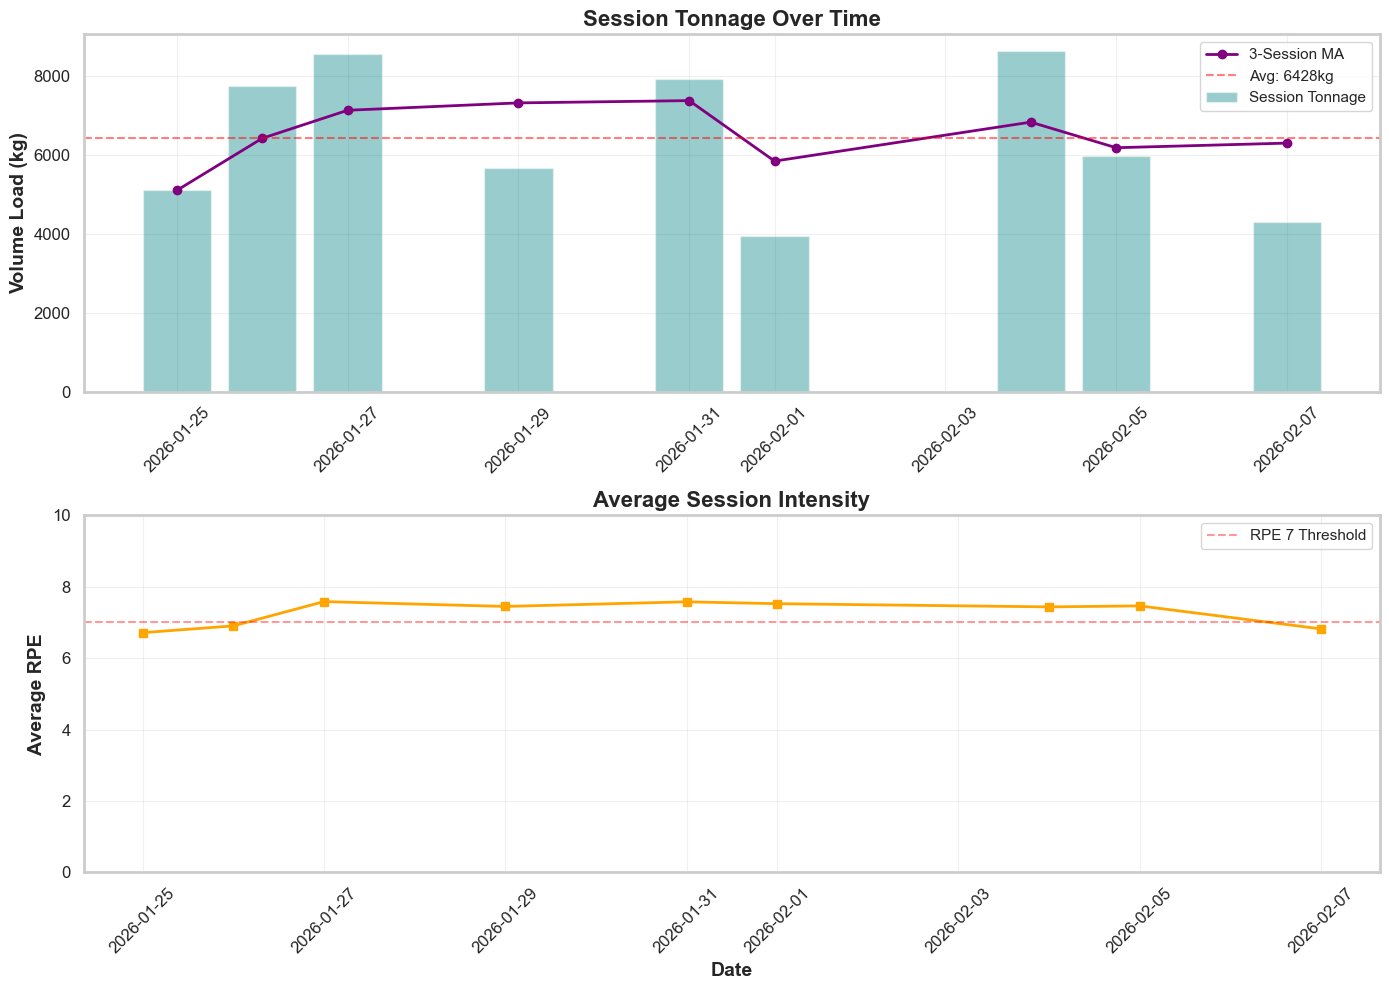

In [30]:
session_stats = df.groupby("Date").agg({
    "Volume_Load": "sum",
    "Intensity_RPE": "mean",
    "Movement": "count"
}).rename(columns={"Movement": "Set_Count"}).reset_index()

session_stats["MA_3"] = session_stats["Volume_Load"].rolling(window=3, min_periods=1).mean()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Volume over time
ax1.bar(session_stats["Date"], session_stats["Volume_Load"], alpha=0.4, color="teal", label="Session Tonnage")
ax1.plot(session_stats["Date"], session_stats["MA_3"], color="purple", linewidth=2, marker="o", label="3-Session MA")
avg_tonnage = session_stats["Volume_Load"].mean()
ax1.axhline(y=avg_tonnage, color="red", linestyle="--", alpha=0.5, label=f"Avg: {avg_tonnage:.0f}kg")
ax1.set_ylabel("Volume Load (kg)")
ax1.set_title("Session Tonnage Over Time")
ax1.legend()
ax1.tick_params(axis="x", rotation=45)

# RPE over time
ax2.plot(session_stats["Date"], session_stats["Intensity_RPE"], marker="s", color="orange", linewidth=2)
ax2.axhline(y=7, color="red", linestyle="--", alpha=0.4, label="RPE 7 Threshold")
ax2.set_ylabel("Average RPE")
ax2.set_xlabel("Date")
ax2.set_ylim(0, 10)
ax2.set_title("Average Session Intensity")
ax2.legend()
ax2.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

## Latest Session Analysis

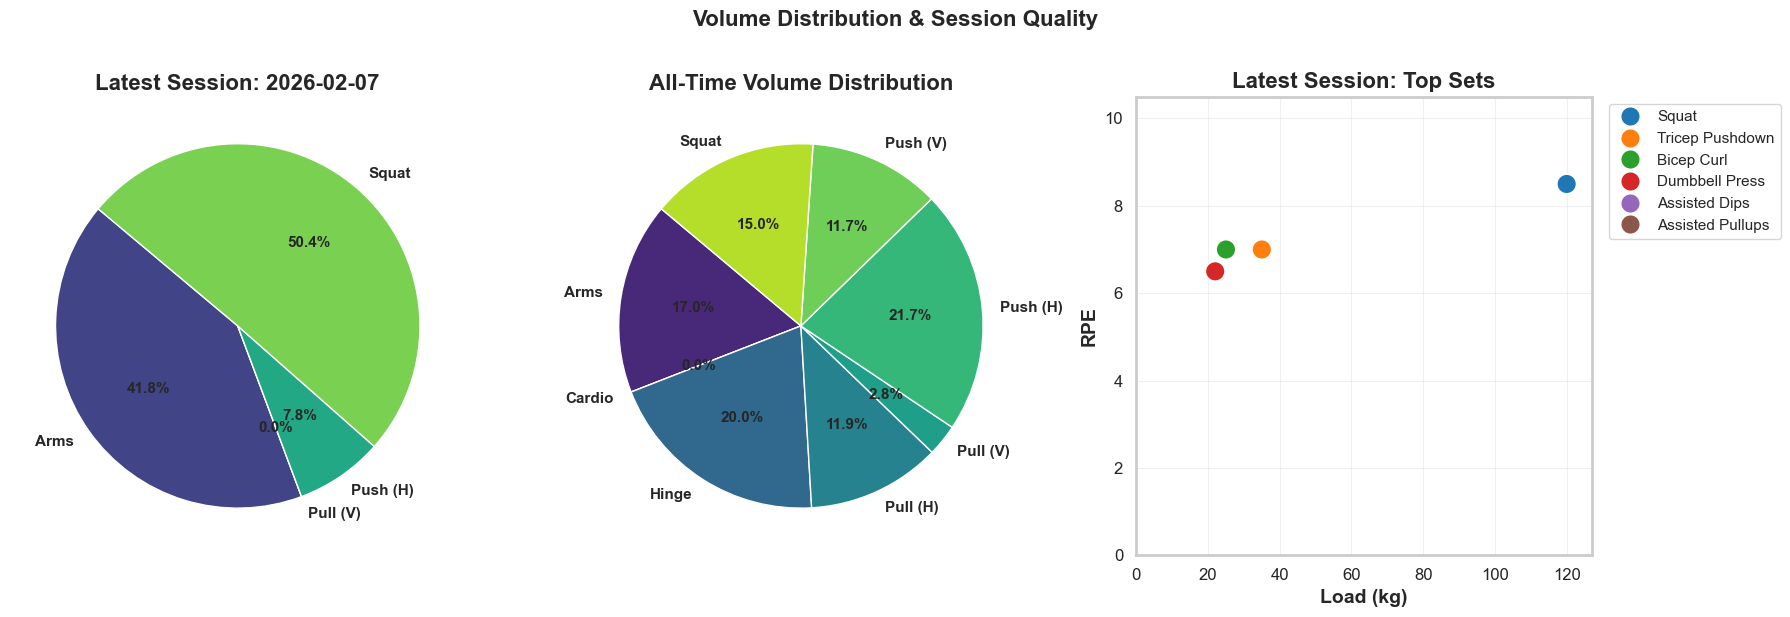

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Volume distribution - Latest Session
family_dist = latest_session.groupby("Family")["Volume_Load"].sum()
axes[0].pie(family_dist, labels=family_dist.index, autopct="%1.1f%%", startangle=140,
            colors=sns.color_palette("viridis", len(family_dist)), 
            textprops={"fontsize": 11, "fontweight": "bold"})
axes[0].set_title(f"Latest Session: {latest_date}")

# 2. Volume distribution - All Time
total_dist = df.groupby("Family")["Volume_Load"].sum()
axes[1].pie(total_dist, labels=total_dist.index, autopct="%1.1f%%", startangle=140,
            colors=sns.color_palette("viridis", len(total_dist)),
            textprops={"fontsize": 11, "fontweight": "bold"})
axes[1].set_title("All-Time Volume Distribution")

# 3. Top sets: Load vs RPE (latest session)
top_sets = latest_session.sort_values("Load_kg", ascending=False).drop_duplicates("Movement")
sns.scatterplot(data=top_sets, x="Load_kg", y="Intensity_RPE", hue="Movement", s=200, ax=axes[2])
axes[2].set_title("Latest Session: Top Sets")
axes[2].set_xlabel("Load (kg)")
axes[2].set_ylabel("RPE")
axes[2].set_xlim(left=0)
axes[2].set_ylim(0, 10.5)
axes[2].legend(bbox_to_anchor=(1.02, 1), loc="upper left")

plt.suptitle("Volume Distribution & Session Quality", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

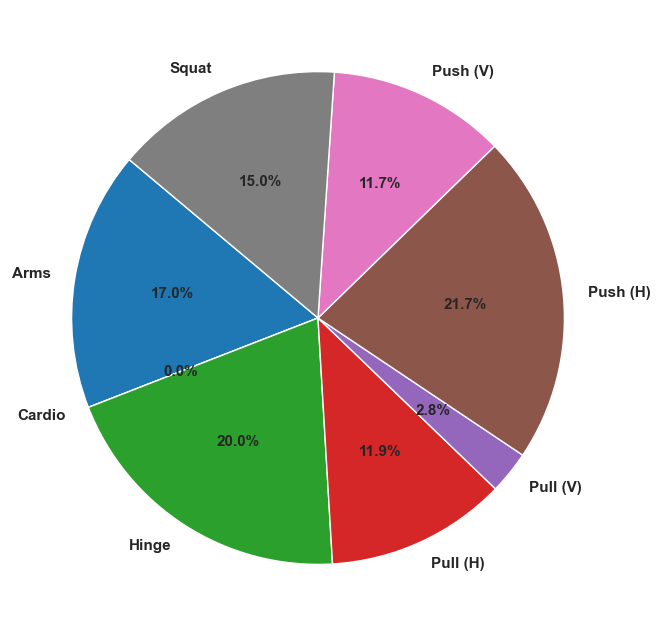

In [32]:
# 2. Volume distribution - All Time
fig, ax = plt.subplots(figsize=(8, 8))

total_dist = df.groupby("Family")["Volume_Load"].sum()
a = ax.pie(total_dist, labels=total_dist.index, autopct="%1.1f%%", startangle=140,
            textprops={"fontsize": 11, "fontweight": "bold"})

## Strength Matrix (Current e1RM)

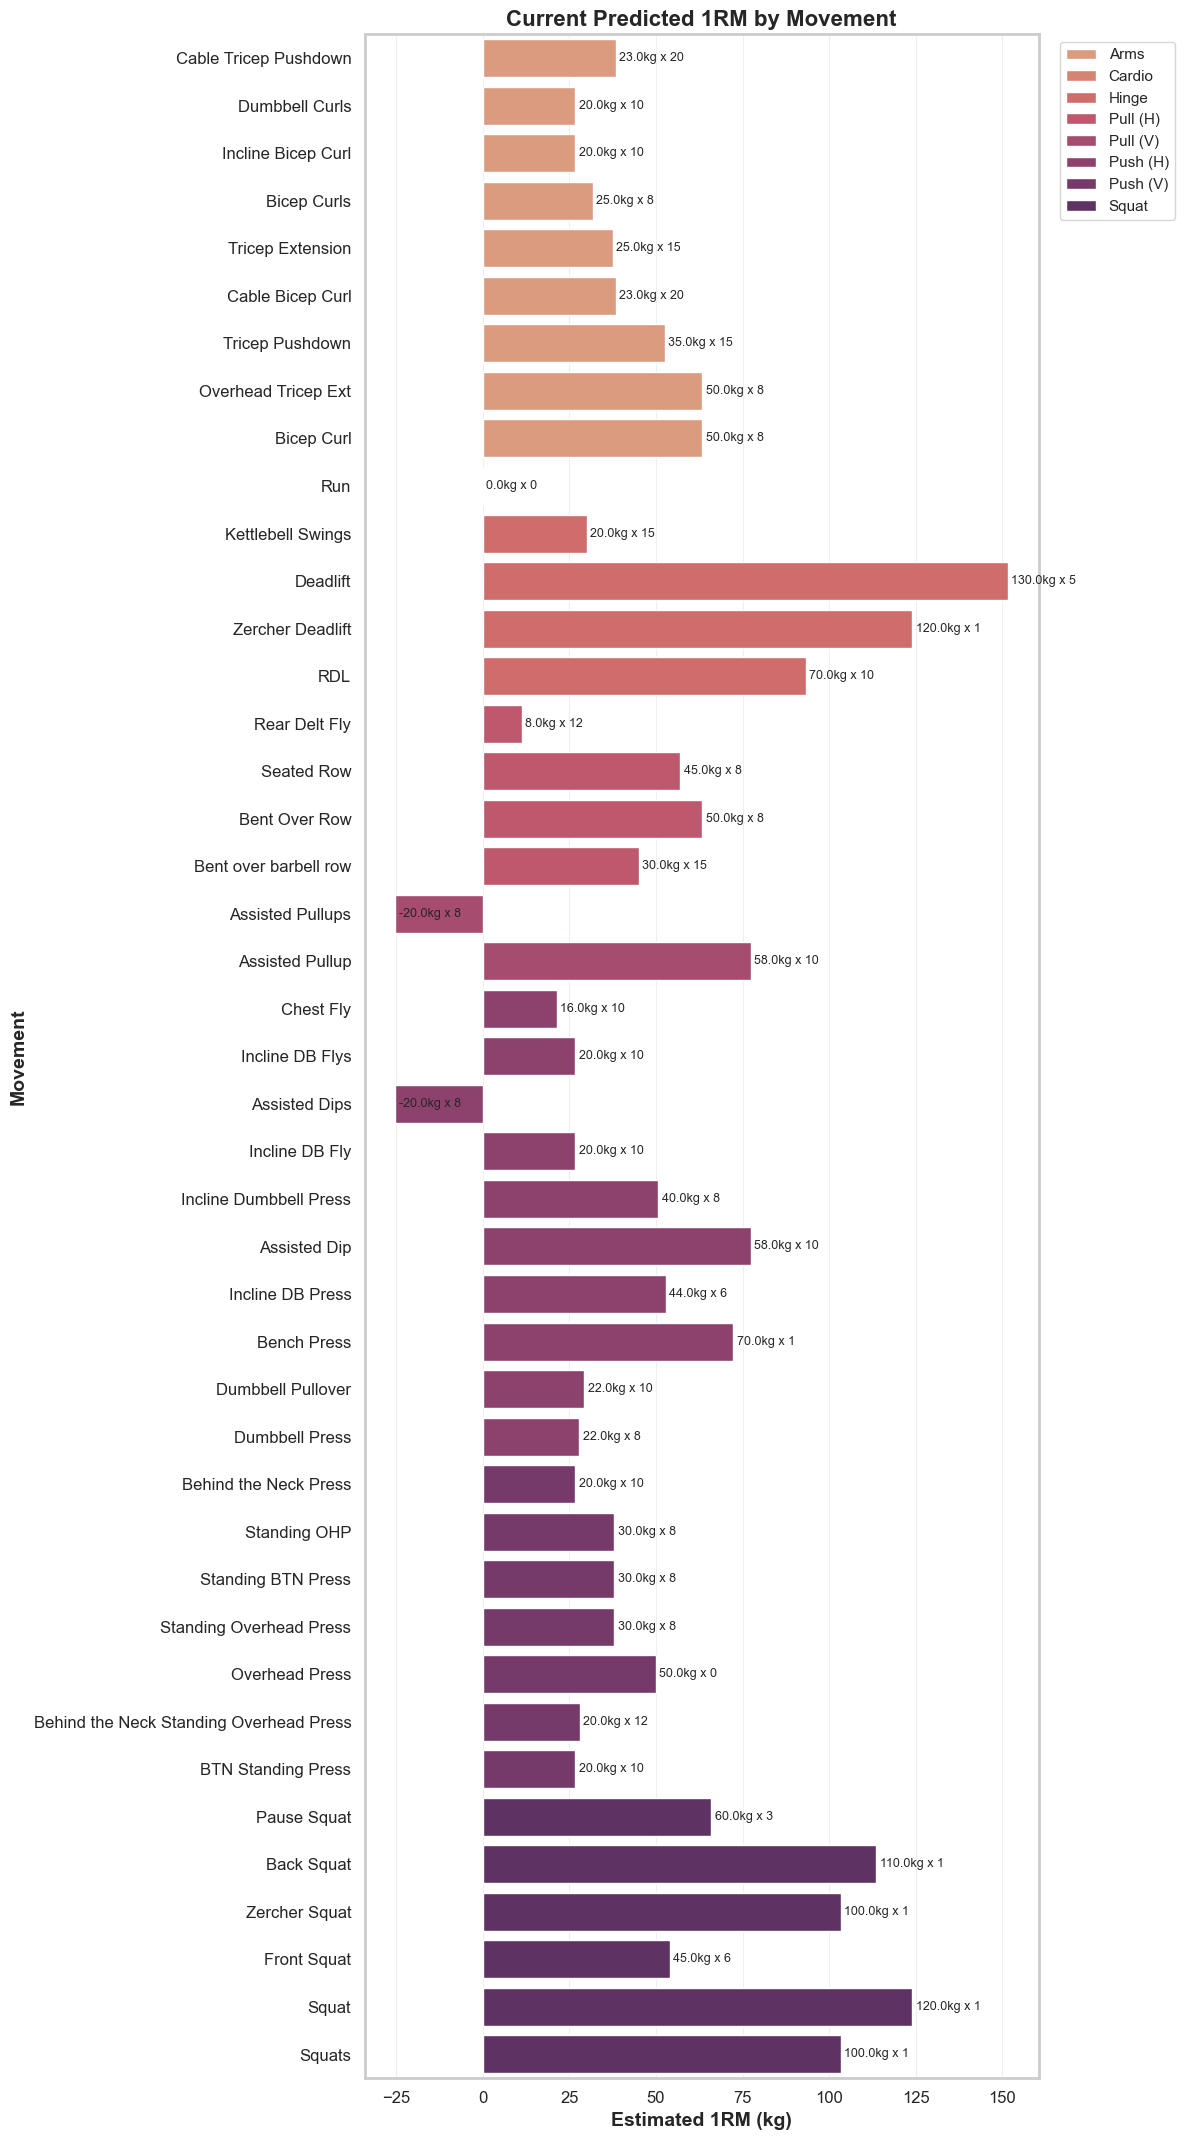

In [33]:
# Get best e1RM for each movement
max_perf = df.sort_values("e1RM", ascending=False).drop_duplicates("Movement")
matrix_data = max_perf[["Movement", "Family", "e1RM", "Load_kg", "Reps"]].sort_values("Family")

plt.figure(figsize=(12, len(matrix_data) * 0.5))
sns.barplot(data=matrix_data, x="e1RM", y="Movement", hue="Family", dodge=False, palette="flare")

for i, row in enumerate(matrix_data.itertuples()):
    plt.text(row.e1RM + 1, i, f"{row.Load_kg}kg x {row.Reps}", va="center", fontsize=9)

plt.title("Current Predicted 1RM by Movement")
plt.xlabel("Estimated 1RM (kg)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

## e1RM Progression Over Time

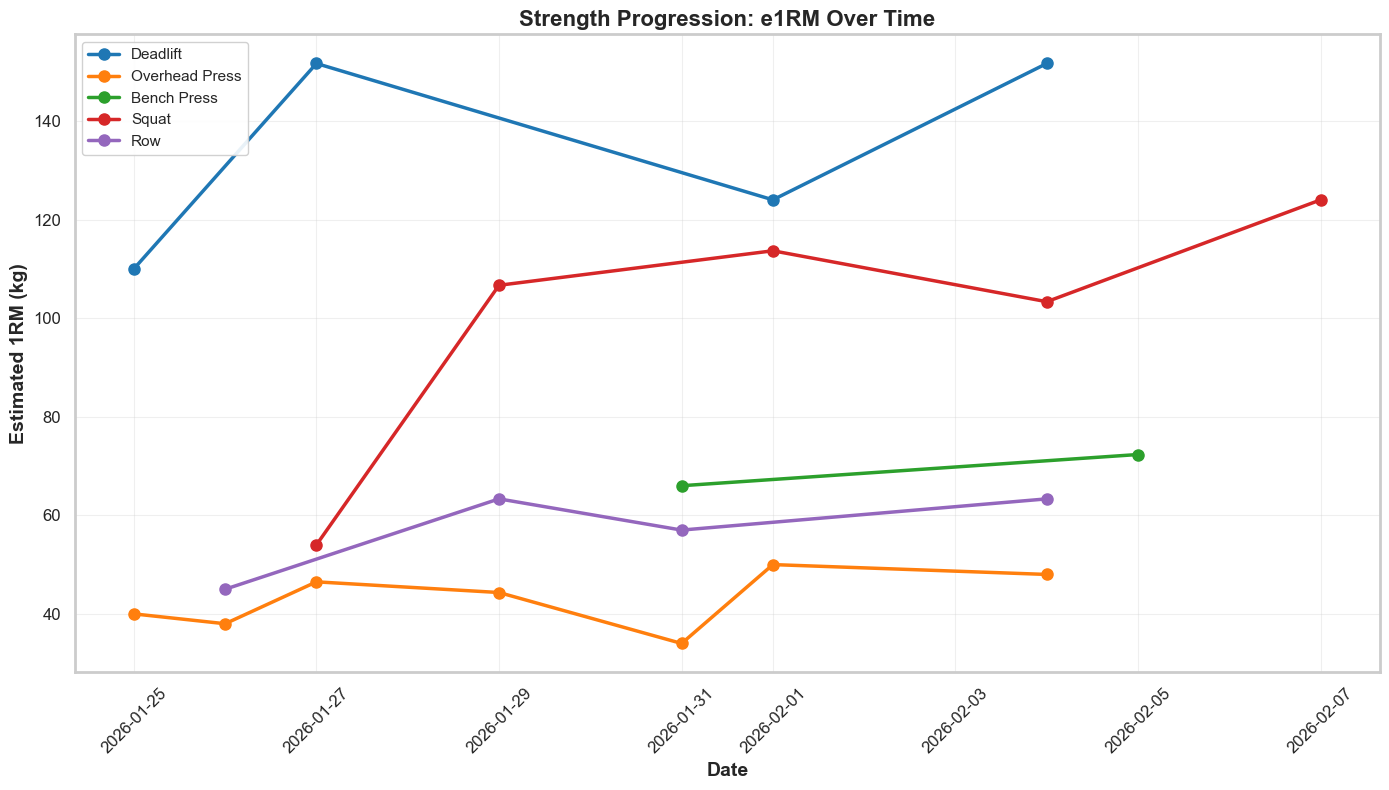

In [34]:
# Track e1RM progression for key compound movements
key_movements = ["Deadlift", "Overhead Press", "Bench Press", "Squat", "Row"]

fig, ax = plt.subplots(figsize=(14, 8))

for move in key_movements:
    move_df = df[df["Movement"].str.contains(move, case=False, na=False)].copy()
    if not move_df.empty:
        # Get best e1RM per session
        best_per_session = move_df.groupby("Date")["e1RM"].max().reset_index()
        ax.plot(best_per_session["Date"], best_per_session["e1RM"], 
                marker="o", linewidth=2.5, markersize=8, label=move)

ax.set_xlabel("Date")
ax.set_ylabel("Estimated 1RM (kg)")
ax.set_title("Strength Progression: e1RM Over Time")
ax.legend(loc="upper left", framealpha=0.9)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

## Movement Pattern Balance

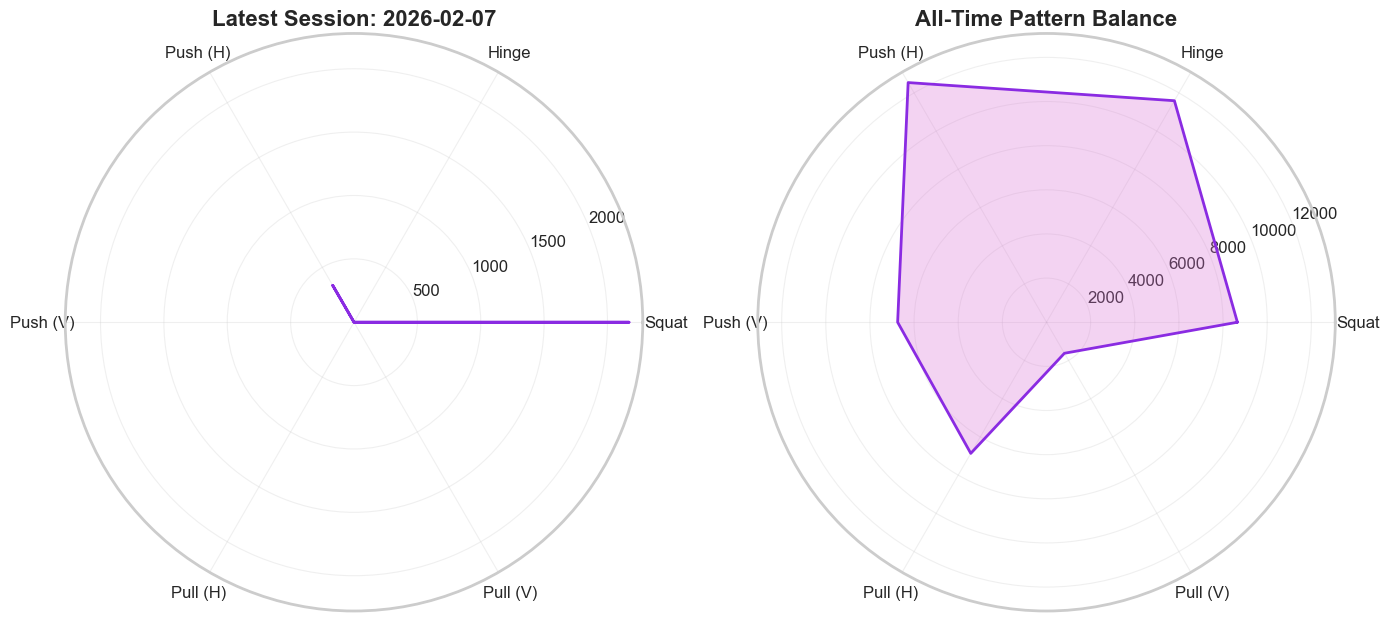

In [35]:
def plot_radar(stats, title, ax):
    """Plot radar chart for movement pattern balance."""
    values = stats.reindex(MOVEMENT_PATTERNS, fill_value=0).values.flatten().tolist()
    values += values[:1]  # Close polygon
    angles = [n / len(MOVEMENT_PATTERNS) * 2 * np.pi for n in range(len(MOVEMENT_PATTERNS))]
    angles += angles[:1]
    
    ax.plot(angles, values, color="#8a2be2", linewidth=2)
    ax.fill(angles, values, color="#da70d6", alpha=0.3)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(MOVEMENT_PATTERNS)
    ax.set_title(title)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), subplot_kw=dict(polar=True))

# Latest session balance
session_vol = latest_session.groupby("Family")["Volume_Load"].sum()
plot_radar(session_vol, f"Latest Session: {latest_date}", ax1)

# All-time balance
total_vol = df.groupby("Family")["Volume_Load"].sum()
plot_radar(total_vol, "All-Time Pattern Balance", ax2)

plt.tight_layout()
plt.show()

## Volume Composition Over Time

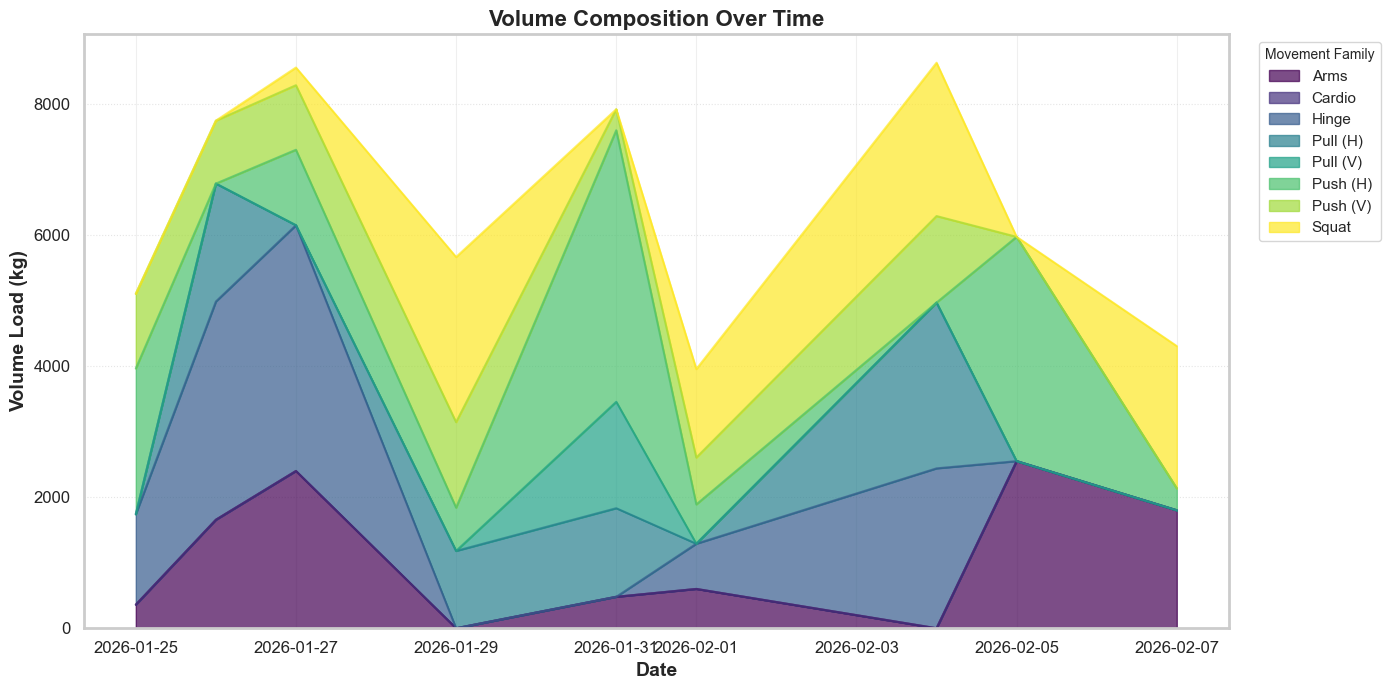

In [36]:
# Stacked area chart by family
pivot_df = df.pivot_table(index="Date", columns="Family", values="Volume_Load", aggfunc="sum").fillna(0)

plt.figure(figsize=(14, 7))
pivot_df.plot(kind="area", stacked=True, ax=plt.gca(), colormap="viridis", alpha=0.7)

plt.title("Volume Composition Over Time")
plt.ylabel("Volume Load (kg)")
plt.xlabel("Date")
plt.legend(title="Movement Family", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(axis="y", linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()

## Set Quality & Training Intensity

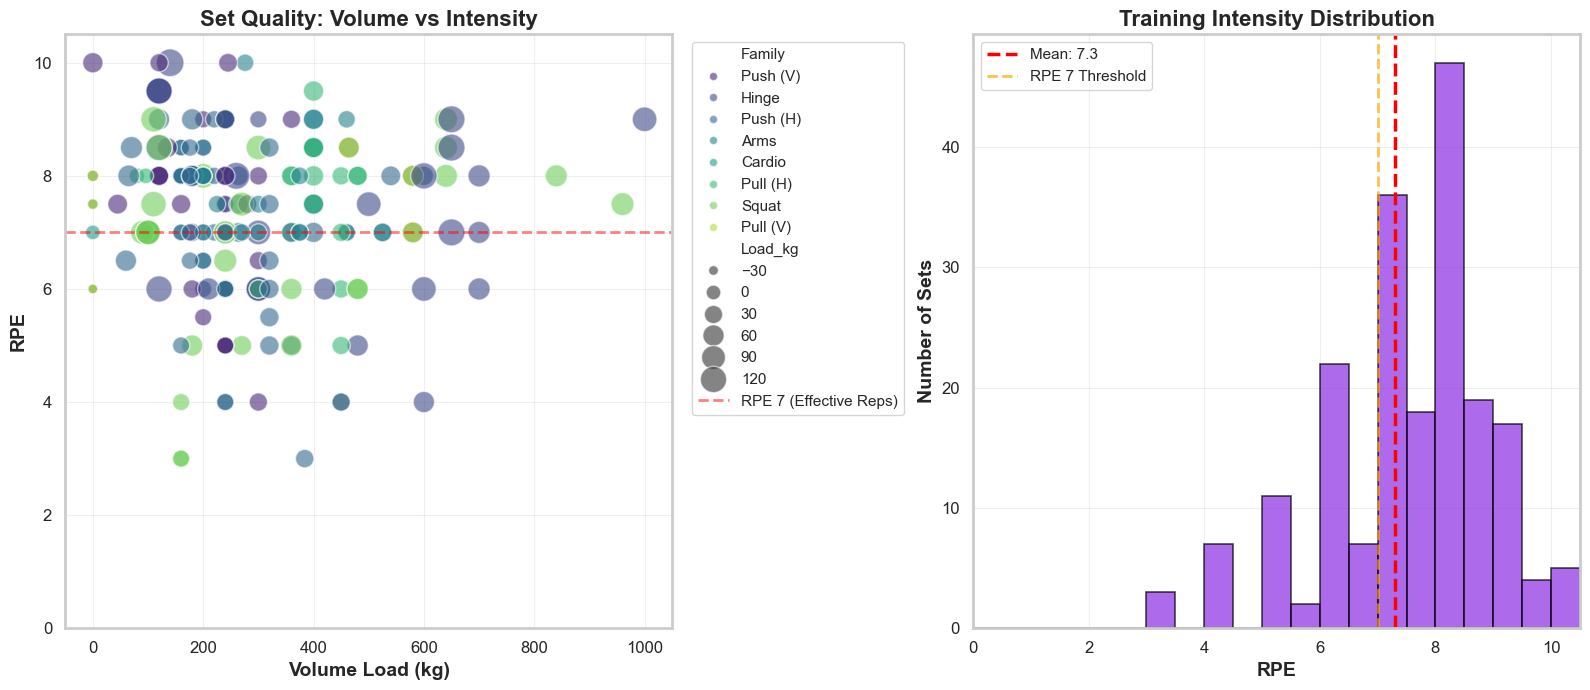


Effective sets (RPE >= 7): 146/198 (74%)


In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# 1. Set Quality Scatter: Volume vs RPE by Family
scatter = sns.scatterplot(data=df, x="Volume_Load", y="Intensity_RPE", 
                          hue="Family", size="Load_kg", sizes=(50, 400), 
                          alpha=0.6, ax=ax1, palette="viridis")
ax1.axhline(y=7, color="red", linestyle="--", linewidth=2, alpha=0.5, label="RPE 7 (Effective Reps)")
ax1.set_xlabel("Volume Load (kg)")
ax1.set_ylabel("RPE")
ax1.set_title("Set Quality: Volume vs Intensity")
ax1.set_ylim(0, 10.5)
ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

# 2. RPE Distribution Histogram
ax2.hist(df["Intensity_RPE"].dropna(), bins=np.arange(0, 11, 0.5), 
         color="#8a2be2", edgecolor="black", linewidth=1.2, alpha=0.7)
ax2.axvline(x=df["Intensity_RPE"].mean(), color="red", linestyle="--", 
            linewidth=2.5, label=f"Mean: {df['Intensity_RPE'].mean():.1f}")
ax2.axvline(x=7, color="orange", linestyle="--", linewidth=2, alpha=0.7, label="RPE 7 Threshold")
ax2.set_xlabel("RPE")
ax2.set_ylabel("Number of Sets")
ax2.set_title("Training Intensity Distribution")
ax2.set_xlim(0, 10.5)
ax2.legend()

plt.tight_layout()
plt.show()

# Summary stats
high_effort = (df["Intensity_RPE"] >= 7).sum()
total_sets = len(df)
print(f"\nEffective sets (RPE >= 7): {high_effort}/{total_sets} ({high_effort/total_sets*100:.0f}%)")

## Training Style Analysis

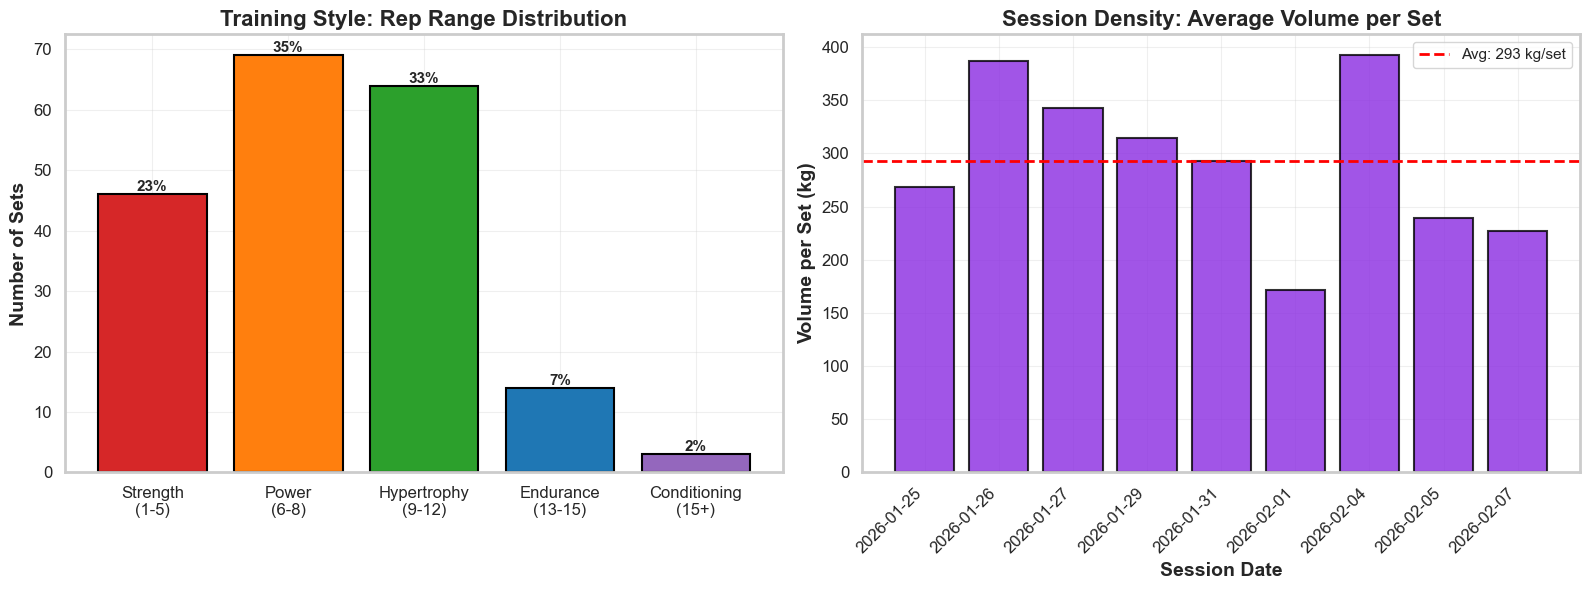


Dominant training style: Power (6-8) (69/196 sets, 35%)


In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Rep Range Distribution - Training Style
rep_bins = [0, 5, 8, 12, 15, 100]
rep_labels = ["Strength\n(1-5)", "Power\n(6-8)", "Hypertrophy\n(9-12)", "Endurance\n(13-15)", "Conditioning\n(15+)"]
df["Rep_Zone"] = pd.cut(df["Reps"], bins=rep_bins, labels=rep_labels, right=True)

zone_counts = df["Rep_Zone"].value_counts().reindex(rep_labels)
colors = ["#d62728", "#ff7f0e", "#2ca02c", "#1f77b4", "#9467bd"]
bars = ax1.bar(zone_counts.index, zone_counts.values, color=colors, edgecolor="black", linewidth=1.5)
ax1.set_ylabel("Number of Sets")
ax1.set_title("Training Style: Rep Range Distribution")

# Add percentage labels
total = zone_counts.sum()
for bar, count in zip(bars, zone_counts.values):
    if count > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f"{count/total*100:.0f}%", ha="center", fontweight="bold", fontsize=11)

# 2. Volume per Set (Session Efficiency)
session_efficiency = df.groupby("Date").agg({
    "Volume_Load": ["sum", "count"]
}).droplevel(0, axis=1)
session_efficiency.columns = ["Total_Volume", "Set_Count"]
session_efficiency["Vol_Per_Set"] = session_efficiency["Total_Volume"] / session_efficiency["Set_Count"]

ax2.bar(range(len(session_efficiency)), session_efficiency["Vol_Per_Set"], 
        color="#8a2be2", edgecolor="black", linewidth=1.5, alpha=0.8)
ax2.axhline(y=session_efficiency["Vol_Per_Set"].mean(), color="red", linestyle="--", 
            linewidth=2, label=f"Avg: {session_efficiency['Vol_Per_Set'].mean():.0f} kg/set")
ax2.set_xticks(range(len(session_efficiency)))
ax2.set_xticklabels([str(d) for d in session_efficiency.index], rotation=45, ha="right")
ax2.set_ylabel("Volume per Set (kg)")
ax2.set_xlabel("Session Date")
ax2.set_title("Session Density: Average Volume per Set")
ax2.legend()

plt.tight_layout()
plt.show()

# Training style summary
dominant_zone = zone_counts.idxmax()
print(f"\nDominant training style: {dominant_zone.replace(chr(10), ' ')} ({zone_counts.max()}/{total} sets, {zone_counts.max()/total*100:.0f}%)")

## 2026 Milestone Progress

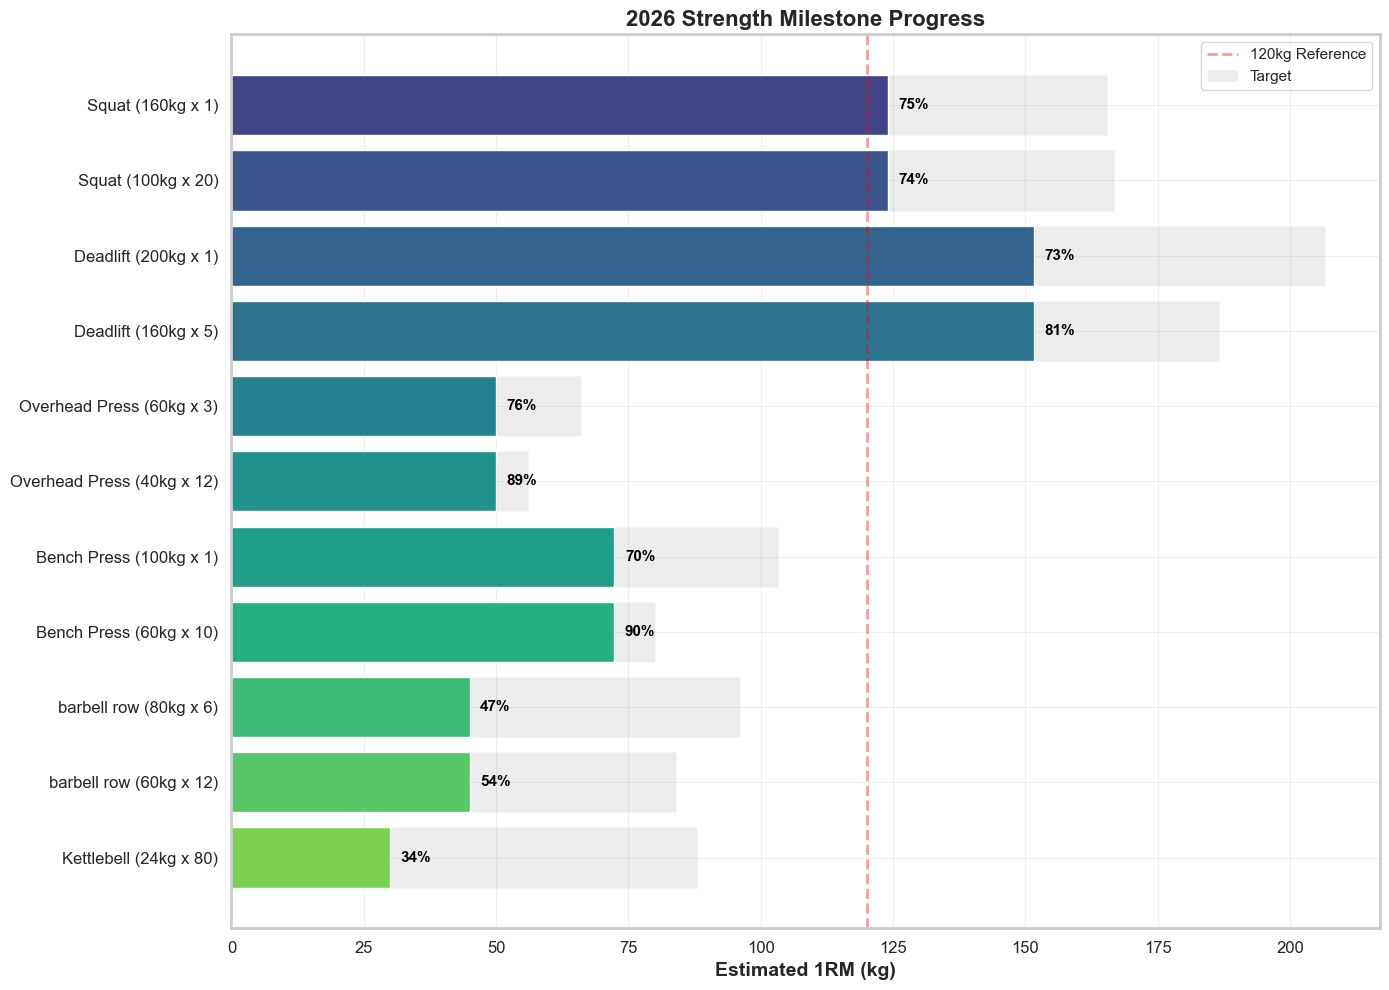


=== Milestone Summary ===
Squat (160kg x 1)                               75% (PR 0d ago)
Squat (100kg x 20)                              74% (PR 0d ago)
Deadlift (200kg x 1)                            73% (PR 10d ago)
Deadlift (160kg x 5)                            81% (PR 10d ago)
Overhead Press (60kg x 3)                       76% (PR 5d ago)
Overhead Press (40kg x 12)                      89% (PR 5d ago)
Bench Press (100kg x 1)                         70% (PR 1d ago)
Bench Press (60kg x 10)                         90% (PR 1d ago)
barbell row (80kg x 6)                          47% (PR 11d ago)
barbell row (60kg x 12)                         54% (PR 11d ago)
Kettlebell (24kg x 80)                          34% (PR 11d ago)


In [39]:
def calculate_milestone_progress(df):
    """Calculate progress toward each milestone goal."""
    today = pd.Timestamp(datetime.now())
    plot_data = []
    
    for move, targets in MILESTONES.items():
        # Find matching movements (case-insensitive partial match)
        family_df = df[df["Movement"].str.contains(move, case=False, na=False)]
        
        if not family_df.empty:
            best_row = family_df.loc[family_df["e1RM"].idxmax()]
            current_e1rm = best_row["e1RM"]
            days_ago = (today - best_row["Timestamp"]).days
        else:
            current_e1rm, days_ago = 0, 365
        
        for weight, reps in targets:
            target_e1rm = weight * (1 + reps / 30)
            plot_data.append({
                "Goal": f"{move} ({weight}kg x {reps})",
                "Current": current_e1rm,
                "Target": target_e1rm,
                "Days Ago": days_ago,
                "Pct": (current_e1rm / target_e1rm * 100) if target_e1rm > 0 else 0
            })
    
    return pd.DataFrame(plot_data)

m_df = calculate_milestone_progress(df)

fig, ax = plt.subplots(figsize=(14, 10))

# Background: target bars
ax.barh(m_df["Goal"], m_df["Target"], color="grey", alpha=0.15, label="Target")

# Foreground: current progress with color gradient
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(m_df)))
ax.barh(m_df["Goal"], m_df["Current"], color=colors)

# Annotations
for i, row in m_df.iterrows():
    color = "green" if row["Pct"] >= 100 else "black"
    ax.text(row["Current"] + 2, i, f"{row['Pct']:.0f}%", va="center", fontweight="bold", color=color, fontsize=11)

ax.axvline(x=120, color="red", linestyle="--", alpha=0.4, linewidth=2, label="120kg Reference")
ax.set_xlabel("Estimated 1RM (kg)")
ax.set_title("2026 Strength Milestone Progress")
ax.legend(loc="upper right")
ax.invert_yaxis()  # Top-to-bottom order

plt.tight_layout()
plt.show()

# Summary table
print("\n=== Milestone Summary ===")
for _, row in m_df.iterrows():
    status = "ACHIEVED" if row["Pct"] >= 100 else f"{row['Pct']:.0f}%"
    print(f"{row['Goal']:40} {status:>10} (PR {row['Days Ago']}d ago)")

## Relative Strength & Lift Ratios

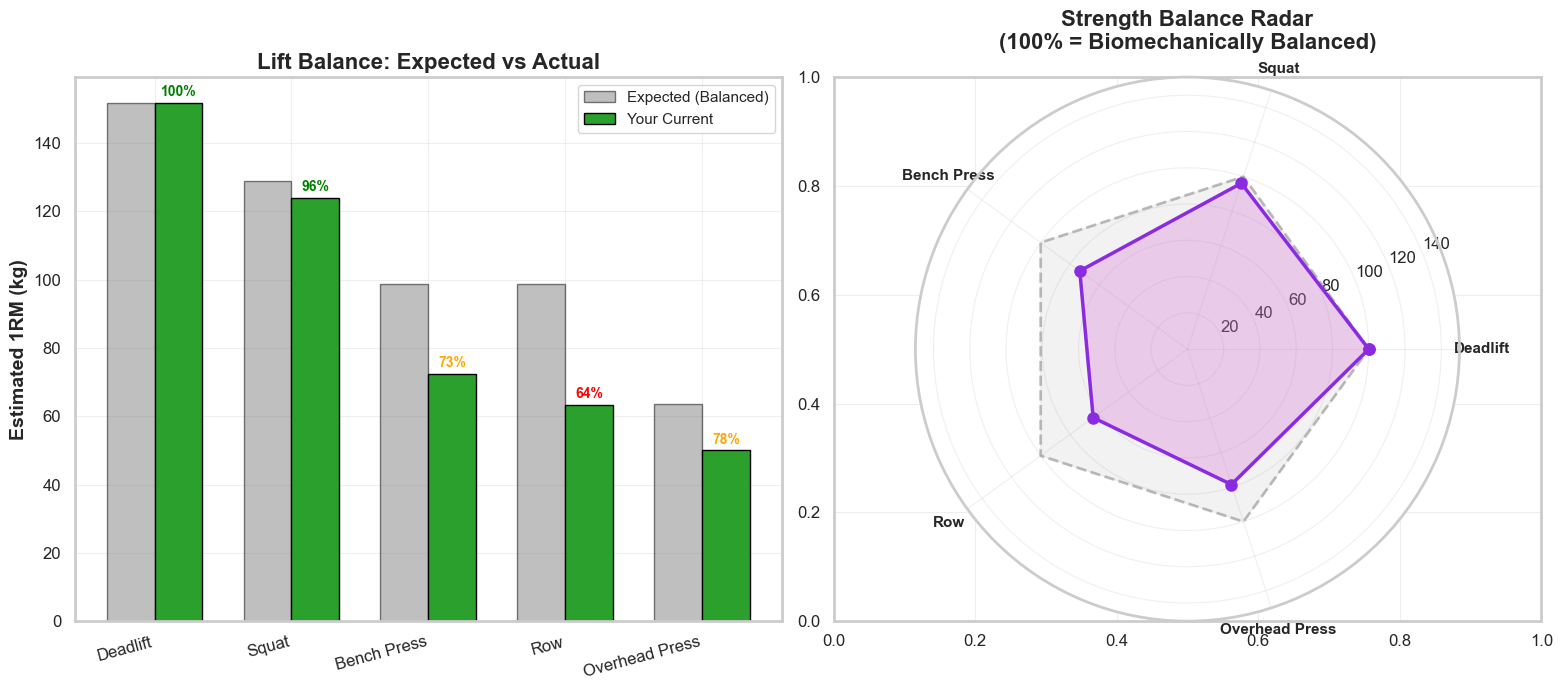


=== Strength Balance Analysis ===
Deadlift              151.7kg /  151.7kg expected =   100% [BALANCED]
Squat                 124.0kg /  128.9kg expected =    96% [BALANCED]
Bench Press            72.3kg /   98.6kg expected =    73% [WEAK]
Row                    63.3kg /   98.6kg expected =    64% [WEAK]
Overhead Press         50.0kg /   63.7kg expected =    78% [WEAK]


In [40]:
# Biomechanical strength ratio benchmarks (relative to Deadlift = 1.0)
# These are approximate ratios for balanced strength
RATIO_BENCHMARKS = {
    "Deadlift": 1.0,
    "Squat": 0.85,        # Squat ~85% of deadlift
    "Bench Press": 0.65,  # Bench ~65% of deadlift  
    "Row": 0.65,          # Row should roughly match bench
    "Overhead Press": 0.42  # OHP ~65% of bench, ~42% of deadlift
}

def get_best_e1rm(df, search_term):
    """Get best e1RM for a movement pattern."""
    matches = df[df["Movement"].str.contains(search_term, case=False, na=False)]
    return matches["e1RM"].max() if not matches.empty else 0

# Calculate current maxes
current_maxes = {
    "Deadlift": get_best_e1rm(df, "Deadlift"),
    "Squat": get_best_e1rm(df, "Squat"),
    "Bench Press": get_best_e1rm(df, "Bench|DB Press"),
    "Row": get_best_e1rm(df, "Row"),
    "Overhead Press": get_best_e1rm(df, "Overhead Press|OHP")
}

# Use deadlift as reference (or strongest lift if no deadlift)
reference_lift = current_maxes["Deadlift"] if current_maxes["Deadlift"] > 0 else max(current_maxes.values())

if reference_lift > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # 1. Actual vs Expected Ratios (radar-style bar comparison)
    lifts = list(RATIO_BENCHMARKS.keys())
    expected = [RATIO_BENCHMARKS[l] * reference_lift for l in lifts]
    actual = [current_maxes[l] for l in lifts]
    
    x = np.arange(len(lifts))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, expected, width, label="Expected (Balanced)", color="grey", alpha=0.5, edgecolor="black")
    bars2 = ax1.bar(x + width/2, actual, width, label="Your Current", color="#2ca02c", edgecolor="black")
    
    ax1.set_ylabel("Estimated 1RM (kg)")
    ax1.set_title("Lift Balance: Expected vs Actual")
    ax1.set_xticks(x)
    ax1.set_xticklabels(lifts, rotation=15, ha="right")
    ax1.legend()
    
    # Add ratio annotations
    for i, (exp, act) in enumerate(zip(expected, actual)):
        if exp > 0:
            ratio = act / exp * 100
            color = "green" if 85 <= ratio <= 115 else ("orange" if 70 <= ratio <= 130 else "red")
            ax1.text(i + width/2, act + 2, f"{ratio:.0f}%", ha="center", fontweight="bold", color=color, fontsize=10)
    
    # 2. Strength Ratio Spider/Polar Chart
    ax2 = plt.subplot(122, projection="polar")
    
    # Normalize to percentage of expected
    ratios = [current_maxes[l] / (RATIO_BENCHMARKS[l] * reference_lift) * 100 
              if RATIO_BENCHMARKS[l] * reference_lift > 0 else 0 for l in lifts]
    
    angles = np.linspace(0, 2 * np.pi, len(lifts), endpoint=False).tolist()
    ratios_closed = ratios + ratios[:1]
    angles_closed = angles + angles[:1]
    
    # 100% reference circle
    ax2.plot(angles_closed, [100] * len(angles_closed), color="grey", linestyle="--", linewidth=2, alpha=0.5, label="Balanced (100%)")
    ax2.fill(angles_closed, [100] * len(angles_closed), color="grey", alpha=0.1)
    
    # Actual ratios
    ax2.plot(angles_closed, ratios_closed, color="#8a2be2", linewidth=2.5, marker="o", markersize=8)
    ax2.fill(angles_closed, ratios_closed, color="#da70d6", alpha=0.3)
    
    ax2.set_xticks(angles)
    ax2.set_xticklabels(lifts, fontsize=11, fontweight="bold")
    ax2.set_ylim(0, max(150, max(ratios) + 20))
    ax2.set_title("Strength Balance Radar\n(100% = Biomechanically Balanced)", pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Imbalance analysis
    print("\n=== Strength Balance Analysis ===")
    for lift in lifts:
        expected_val = RATIO_BENCHMARKS[lift] * reference_lift
        actual_val = current_maxes[lift]
        if expected_val > 0:
            ratio = actual_val / expected_val * 100
            status = "BALANCED" if 85 <= ratio <= 115 else ("WEAK" if ratio < 85 else "STRONG")
            print(f"{lift:20} {actual_val:6.1f}kg / {expected_val:6.1f}kg expected = {ratio:5.0f}% [{status}]")
else:
    print("Need deadlift or other compound lift data for ratio analysis.")

## PR Timeline & Records

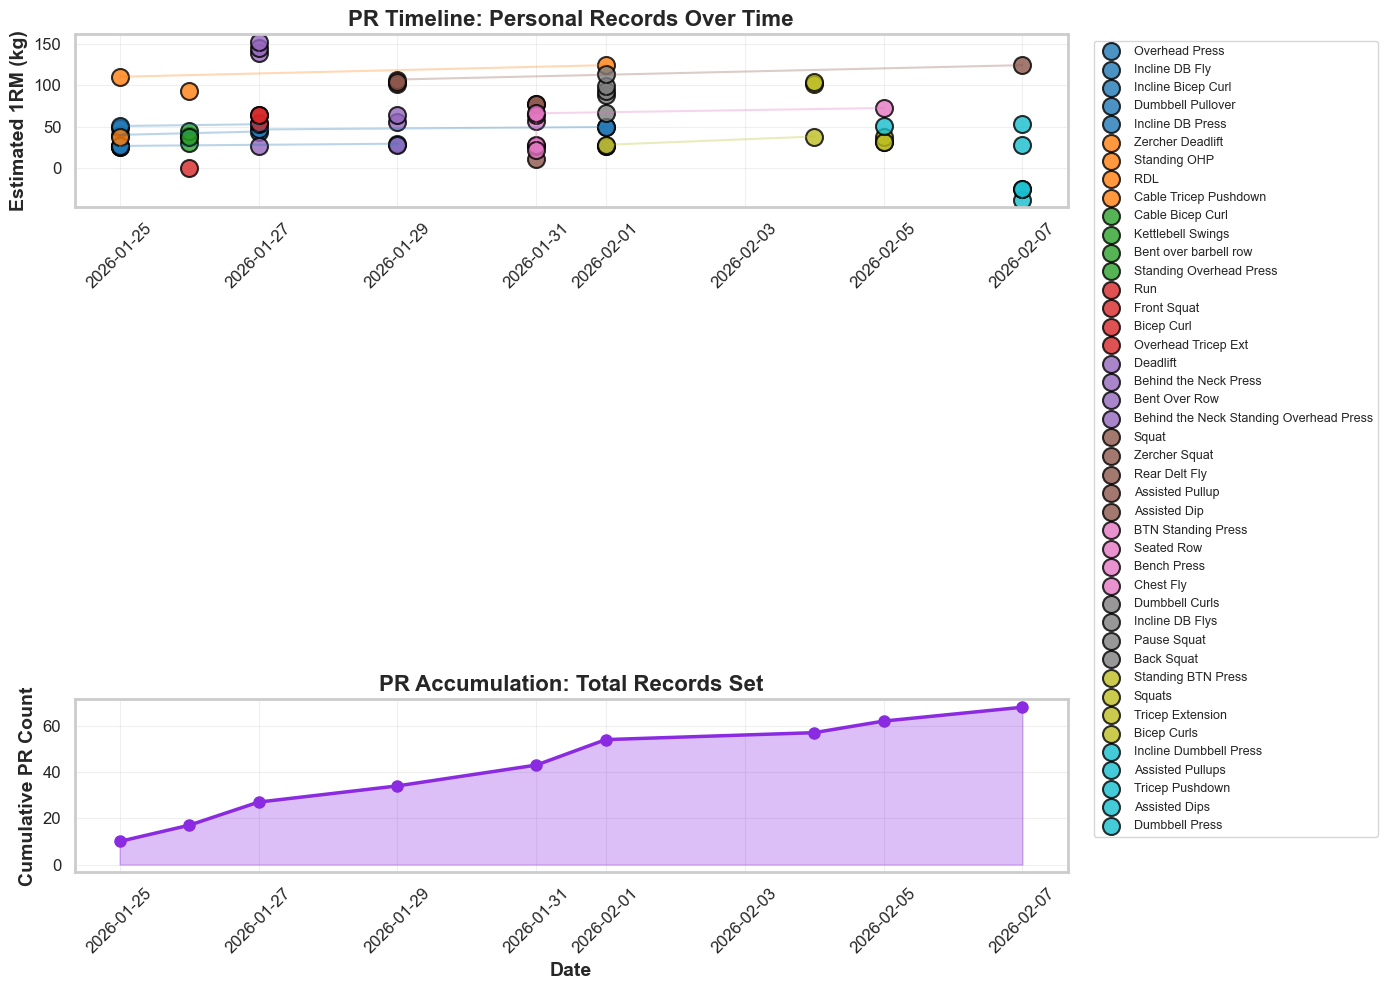


=== Current Personal Records ===
Deadlift                        151.7kg  (130.0kg x 5)  [2026-01-27]
Zercher Deadlift                124.0kg  (120.0kg x 1)  [2026-02-01]
Squat                           124.0kg  (120.0kg x 1)  [2026-02-07]
Zercher Squat                   103.3kg  (100.0kg x 1)  [2026-01-29]
Squats                          103.3kg  (100.0kg x 1)  [2026-02-04]
RDL                              93.3kg  (70.0kg x 10)  [2026-01-26]
Back Squat                       88.0kg  (80.0kg x 3)  [2026-02-01]
Assisted Dip                     77.3kg  (58.0kg x 10)  [2026-01-31]
Assisted Pullup                  77.3kg  (58.0kg x 10)  [2026-01-31]
Bench Press                      72.3kg  (70.0kg x 1)  [2026-02-05]
Pause Squat                      66.0kg  (60.0kg x 3)  [2026-02-01]
Overhead Tricep Ext              63.3kg  (50.0kg x 8)  [2026-01-27]
Bent Over Row                    63.3kg  (50.0kg x 8)  [2026-01-29]
Bicep Curl                       63.3kg  (50.0kg x 8)  [2026-01-27]
Seated

In [41]:
# Find PR (personal record) for each movement over time
def calculate_prs(df):
    """Track cumulative PRs for each movement."""
    pr_records = []
    movement_prs = {}  # Track current PR for each movement
    
    for _, row in df.sort_values("Timestamp").iterrows():
        move = row["Movement"]
        e1rm = row["e1RM"]
        date = row["Date"]
        
        if move not in movement_prs or e1rm > movement_prs[move]:
            movement_prs[move] = e1rm
            pr_records.append({
                "Date": date,
                "Movement": move,
                "e1RM": e1rm,
                "Load_kg": row["Load_kg"],
                "Reps": row["Reps"]
            })
    
    return pd.DataFrame(pr_records)

pr_df = calculate_prs(df)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# 1. PR Timeline - scatter plot of all PRs
movements = pr_df["Movement"].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(movements)))
move_colors = dict(zip(movements, colors))

for move in movements:
    move_prs = pr_df[pr_df["Movement"] == move]
    ax1.scatter(move_prs["Date"], move_prs["e1RM"], 
                label=move, s=150, alpha=0.8, edgecolor="black", linewidth=1.5,
                c=[move_colors[move]])
    # Connect PRs with lines
    if len(move_prs) > 1:
        ax1.plot(move_prs["Date"], move_prs["e1RM"], 
                 alpha=0.3, linewidth=1.5, c=move_colors[move])

ax1.set_ylabel("Estimated 1RM (kg)")
ax1.set_title("PR Timeline: Personal Records Over Time")
ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)
ax1.tick_params(axis="x", rotation=45)

# 2. PR Count by Date - cumulative PRs
pr_counts = pr_df.groupby("Date").size().cumsum()
ax2.fill_between(pr_counts.index, pr_counts.values, alpha=0.3, color="#8a2be2")
ax2.plot(pr_counts.index, pr_counts.values, color="#8a2be2", linewidth=2.5, marker="o", markersize=8)
ax2.set_ylabel("Cumulative PR Count")
ax2.set_xlabel("Date")
ax2.set_title("PR Accumulation: Total Records Set")
ax2.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

# PR Table
print("\n=== Current Personal Records ===")
current_prs = pr_df.sort_values("Date").drop_duplicates("Movement", keep="last").sort_values("e1RM", ascending=False)
for _, row in current_prs.iterrows():
    print(f"{row['Movement']:30} {row['e1RM']:6.1f}kg  ({row['Load_kg']}kg x {row['Reps']})  [{row['Date']}]")

## Programming Effectiveness: Rate of Progression

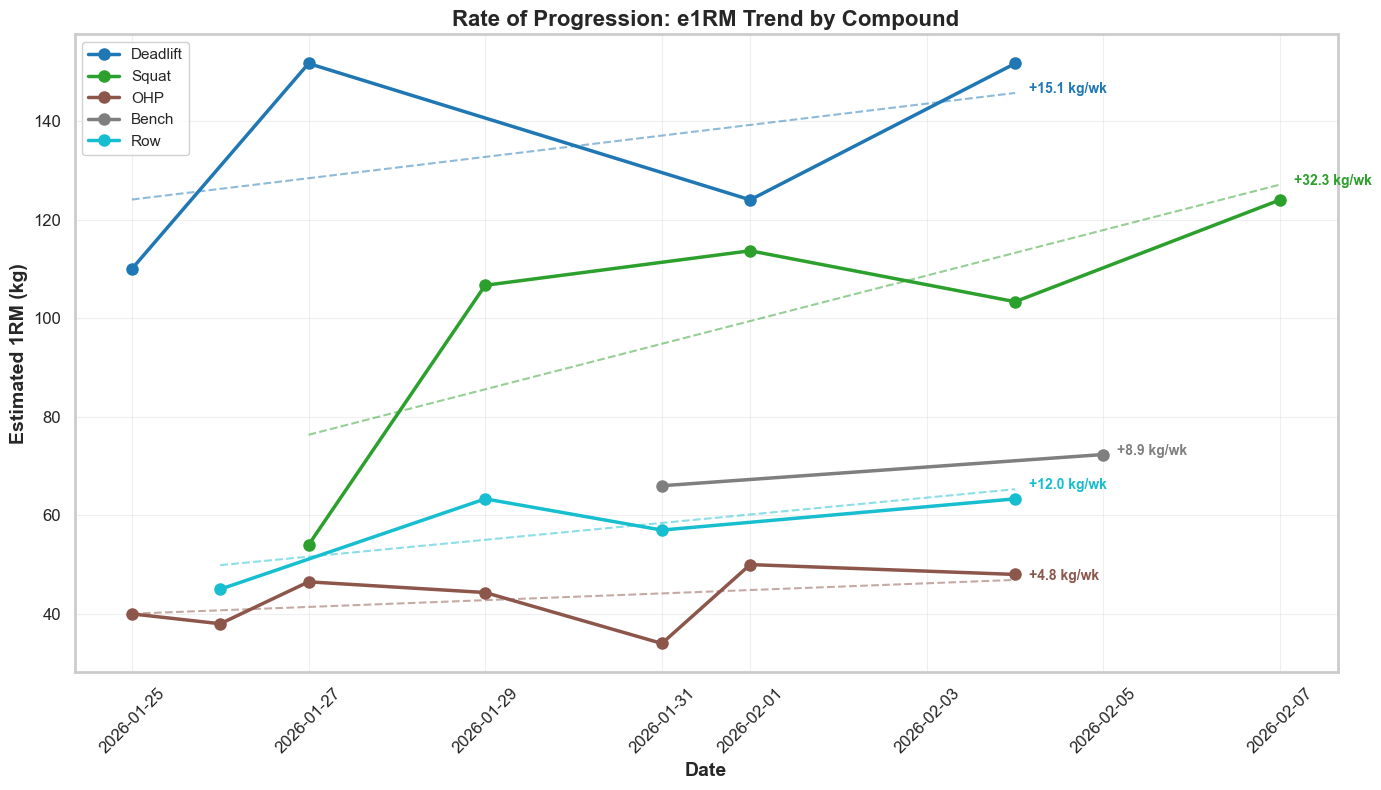

In [44]:
from scipy import stats as scipy_stats

key_compounds = {
    "Deadlift": "Deadlift",
    "Squat": "Squat",
    "OHP": "Overhead Press|OHP",
    "Bench": "Bench",
    "Row": "Row"
}

fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(key_compounds)))

for (label, pattern), color in zip(key_compounds.items(), colors):
    move_df = df[df["Movement"].str.contains(pattern, case=False, na=False)]
    if move_df.empty:
        continue
    best_per_session = move_df.groupby("Date")["e1RM"].max().reset_index()
    if len(best_per_session) < 2:
        ax.scatter(best_per_session["Date"], best_per_session["e1RM"],
                   label=label, s=100, color=color)
        continue

    ax.plot(best_per_session["Date"], best_per_session["e1RM"],
            marker="o", linewidth=2.5, markersize=8, label=label, color=color)

    # Linear regression for trend
    x_num = (best_per_session["Date"] - best_per_session["Date"].min()).apply(lambda d: d.days).values
    y_vals = best_per_session["e1RM"].values
    slope, intercept, r, _, _ = scipy_stats.linregress(x_num, y_vals)
    trend_y = slope * x_num + intercept
    ax.plot(best_per_session["Date"], trend_y, linestyle="--", color=color, alpha=0.5, linewidth=1.5)

    # Annotate with kg/week
    kg_per_week = slope * 7
    ax.annotate(f"{kg_per_week:+.1f} kg/wk",
                xy=(best_per_session["Date"].iloc[-1], trend_y[-1]),
                fontweight="bold", fontsize=10, color=color,
                xytext=(10, 0), textcoords="offset points")

ax.set_xlabel("Date")
ax.set_ylabel("Estimated 1RM (kg)")
ax.set_title("Rate of Progression: e1RM Trend by Compound")
ax.legend(loc="upper left", framealpha=0.9)
ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

## Programming Effectiveness: Effective Volume

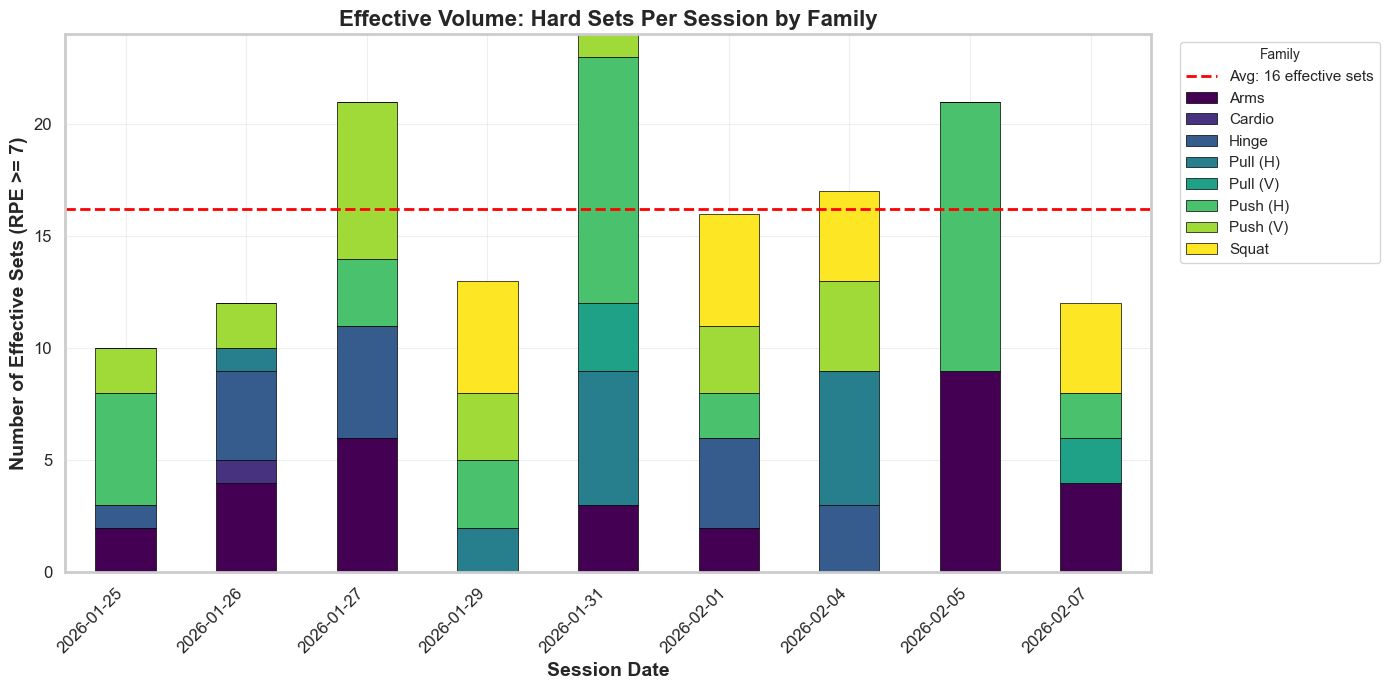


Effective sets per session: 16.2 / 22.0 total (74%)


In [45]:
# Count effective sets (RPE >= 7) per session by family
effective = df[df["Intensity_RPE"] >= 7].copy()
eff_pivot = effective.pivot_table(index="Date", columns="Family", values="Movement",
                                   aggfunc="count").fillna(0)

fig, ax = plt.subplots(figsize=(14, 7))
eff_pivot.plot(kind="bar", stacked=True, ax=ax, colormap="viridis", edgecolor="black", linewidth=0.5)

# Average effective sets per session
total_eff_per_session = effective.groupby("Date").size()
avg_eff = total_eff_per_session.mean()
ax.axhline(y=avg_eff, color="red", linestyle="--", linewidth=2, label=f"Avg: {avg_eff:.0f} effective sets")

ax.set_ylabel("Number of Effective Sets (RPE >= 7)")
ax.set_xlabel("Session Date")
ax.set_title("Effective Volume: Hard Sets Per Session by Family")
ax.legend(title="Family", bbox_to_anchor=(1.02, 1), loc="upper left")
ax.set_xticklabels([str(d.date()) if hasattr(d, 'date') else str(d) for d in eff_pivot.index], rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Summary
total_sets_per_session = df.groupby("Date").size()
print(f"\nEffective sets per session: {avg_eff:.1f} / {total_sets_per_session.mean():.1f} total ({avg_eff/total_sets_per_session.mean()*100:.0f}%)")

## Programming Effectiveness: Volume-Strength Relationship

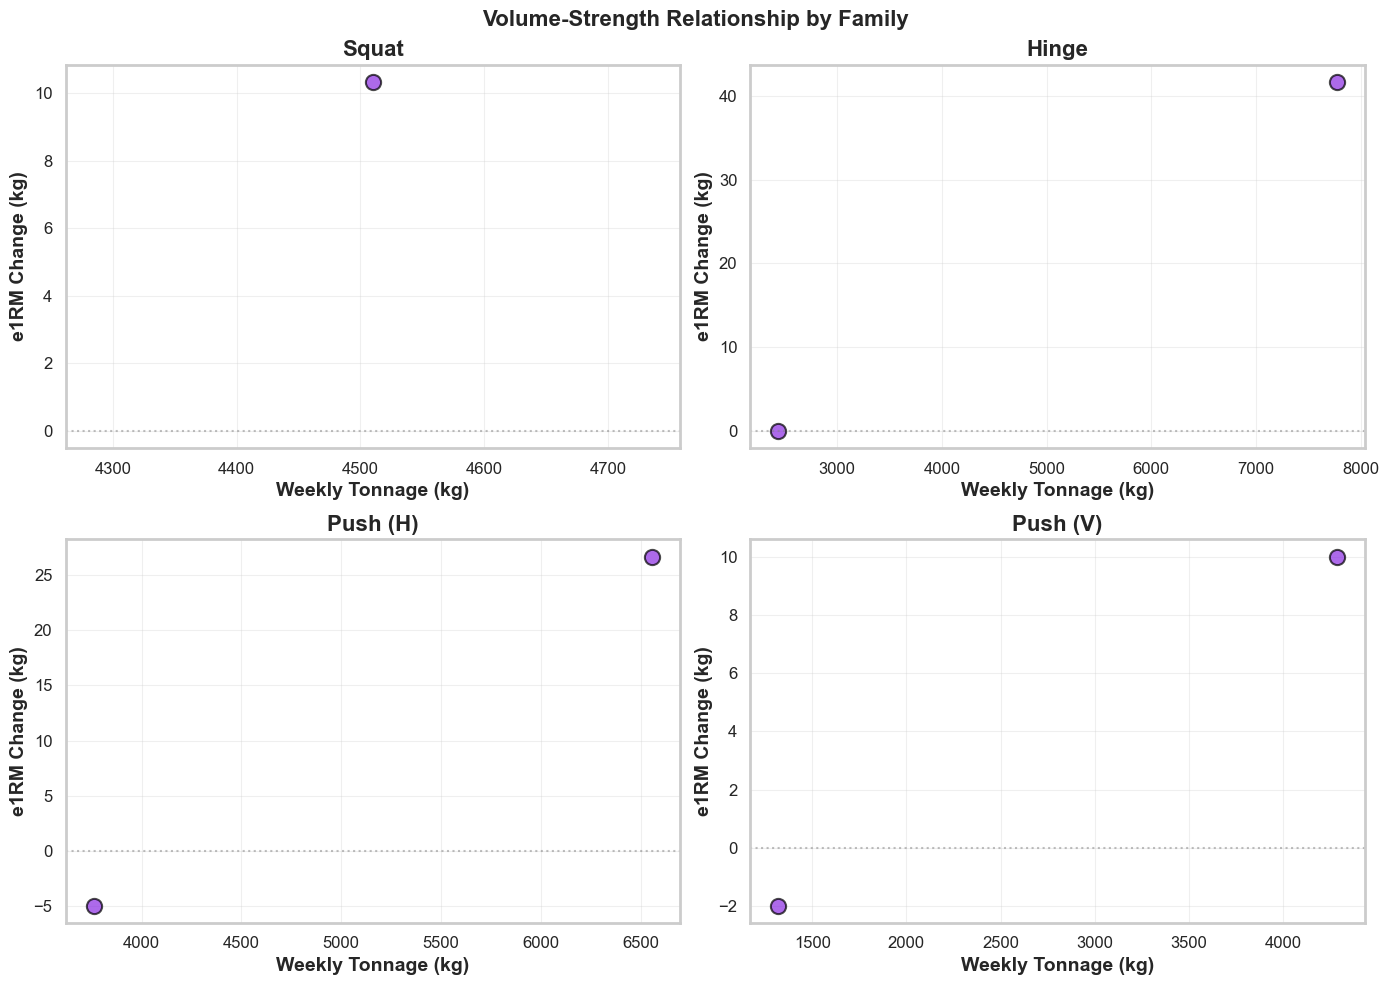

In [46]:
# Weekly volume vs e1RM change per compound family
df_copy = df.copy()
df_copy["Week"] = pd.to_datetime(df_copy["Date"].astype(str)).dt.isocalendar().week.astype(int)
df_copy["Year"] = pd.to_datetime(df_copy["Date"].astype(str)).dt.year

compound_families = ["Squat", "Hinge", "Push (H)", "Push (V)"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, family in zip(axes.flatten(), compound_families):
    fam_df = df_copy[df_copy["Family"] == family]
    if fam_df.empty:
        ax.set_title(f"{family} (no data)")
        continue

    weekly = fam_df.groupby(["Year", "Week"]).agg(
        tonnage=("Volume_Load", "sum"),
        best_e1rm=("e1RM", "max")
    ).reset_index()

    weekly["e1rm_delta"] = weekly["best_e1rm"].diff()
    weekly = weekly.dropna(subset=["e1rm_delta"])

    if weekly.empty:
        ax.set_title(f"{family} (need 2+ weeks)")
        continue

    ax.scatter(weekly["tonnage"], weekly["e1rm_delta"], s=120, alpha=0.7,
               edgecolor="black", linewidth=1.5, color="#8a2be2")

    # Trend line if enough points
    if len(weekly) >= 3:
        z = np.polyfit(weekly["tonnage"], weekly["e1rm_delta"], 1)
        p = np.poly1d(z)
        x_line = np.linspace(weekly["tonnage"].min(), weekly["tonnage"].max(), 50)
        ax.plot(x_line, p(x_line), "--", color="red", alpha=0.6, linewidth=2)

    ax.axhline(y=0, color="grey", linestyle=":", alpha=0.5)
    ax.set_xlabel("Weekly Tonnage (kg)")
    ax.set_ylabel("e1RM Change (kg)")
    ax.set_title(f"{family}")

plt.suptitle("Volume-Strength Relationship by Family", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

## Programming Effectiveness: Stall Detection

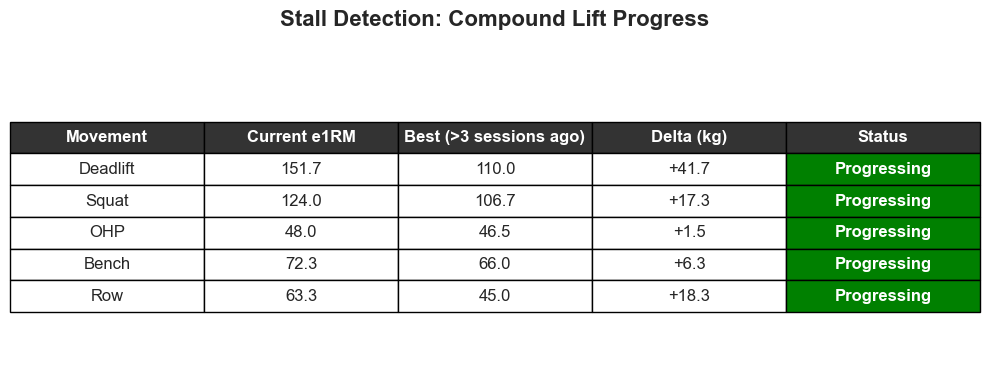

In [47]:
# Stall detection: compare current best e1RM vs best from 3 sessions ago
LOOKBACK_SESSIONS = 3
session_dates = sorted(df["Date"].unique())

stall_data = []
for label, pattern in key_compounds.items():
    move_df = df[df["Movement"].str.contains(pattern, case=False, na=False)]
    if move_df.empty:
        continue

    best_per_session = move_df.groupby("Date")["e1RM"].max().reset_index().sort_values("Date")

    current_best = best_per_session["e1RM"].iloc[-1]
    if len(best_per_session) > LOOKBACK_SESSIONS:
        previous_best = best_per_session["e1RM"].iloc[:-LOOKBACK_SESSIONS].max()
    else:
        previous_best = best_per_session["e1RM"].iloc[0]

    delta = current_best - previous_best
    if delta > 1:
        status, color = "Progressing", "green"
    elif delta >= -1:
        status, color = "Plateaued", "#CC8800"
    else:
        status, color = "Regressing", "red"

    stall_data.append({
        "Movement": label,
        "Current e1RM": f"{current_best:.1f}",
        "Previous e1RM": f"{previous_best:.1f}",
        "Delta": f"{delta:+.1f}",
        "Status": status,
        "color": color
    })

# Display as colored table
fig, ax = plt.subplots(figsize=(10, len(stall_data) * 0.6 + 1))
ax.axis("off")

col_labels = ["Movement", "Current e1RM", f"Best (>{LOOKBACK_SESSIONS} sessions ago)", "Delta (kg)", "Status"]
cell_text = [[d["Movement"], d["Current e1RM"], d["Previous e1RM"], d["Delta"], d["Status"]] for d in stall_data]
cell_colors = [["white", "white", "white", "white", d["color"]] for d in stall_data]

table = ax.table(cellText=cell_text, colLabels=col_labels, loc="center", cellLoc="center")
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.8)

# Color the status cells
for i, d in enumerate(stall_data):
    table[i + 1, 4].set_facecolor(d["color"])
    table[i + 1, 4].set_text_props(color="white", fontweight="bold")

# Bold headers
for j in range(len(col_labels)):
    table[0, j].set_text_props(fontweight="bold")
    table[0, j].set_facecolor("#333333")
    table[0, j].set_text_props(color="white", fontweight="bold")

ax.set_title("Stall Detection: Compound Lift Progress", fontsize=16, fontweight="bold", pad=20)
plt.tight_layout()
plt.show()

## Recovery: Training Frequency Heatmap

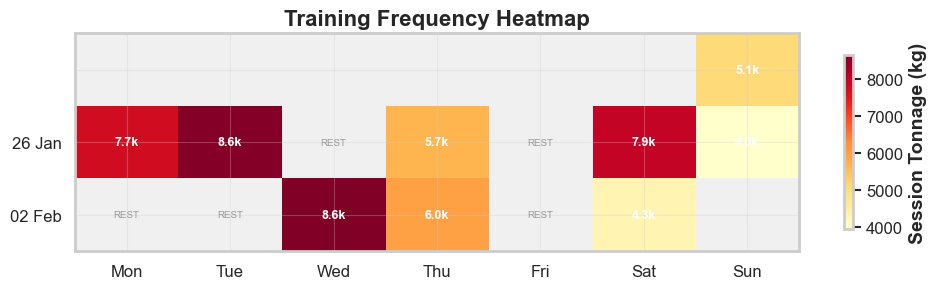


Training frequency: 9 sessions over 14 days
Average gap between sessions: 1.6 days
Longest rest: 3 days | Shortest rest: 1 days

Days since last training by family:
  Squat        0d ago
  Hinge        3d ago
  Push (H)     0d ago
  Push (V)     3d ago
  Pull (H)     3d ago
  Pull (V)     0d ago


In [48]:
import calendar

# Build calendar data
session_stats_cal = df.groupby("Date").agg(
    tonnage=("Volume_Load", "sum"),
    avg_rpe=("Intensity_RPE", "mean")
).reset_index()

# Create date range from first to last session
all_dates = pd.date_range(
    start=min(df["Date"]),
    end=max(df["Date"]),
    freq="D"
)

# Map dates to values
date_tonnage = dict(zip(session_stats_cal["Date"], session_stats_cal["tonnage"]))

# Build week-based grid
weeks = []
current_week = []
for d in all_dates:
    if d.weekday() == 0 and current_week:
        weeks.append(current_week)
        current_week = []
    current_week.append(d.date())
if current_week:
    weeks.append(current_week)

# Pad first week
first_weekday = all_dates[0].weekday()
if first_weekday > 0:
    weeks[0] = [None] * first_weekday + weeks[0]
# Pad last week
if len(weeks[-1]) < 7:
    weeks[-1] = weeks[-1] + [None] * (7 - len(weeks[-1]))

# Build heatmap matrix
grid = np.full((len(weeks), 7), np.nan)
for i, week in enumerate(weeks):
    for j, d in enumerate(week):
        if d and d in date_tonnage:
            grid[i, j] = date_tonnage[d]

fig, ax = plt.subplots(figsize=(10, max(3, len(weeks) * 0.8)))

cmap = plt.cm.YlOrRd.copy()
cmap.set_bad(color="#f0f0f0")
im = ax.imshow(grid, cmap=cmap, aspect="auto")

ax.set_xticks(range(7))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
ax.set_yticks(range(len(weeks)))
ax.set_yticklabels([weeks[i][0].strftime("%d %b") if weeks[i][0] else "" for i in range(len(weeks))])

# Annotate cells
for i in range(len(weeks)):
    for j in range(7):
        d = weeks[i][j] if j < len(weeks[i]) else None
        if d is None:
            continue
        if d in date_tonnage:
            ax.text(j, i, f"{date_tonnage[d]/1000:.1f}k", ha="center", va="center",
                    fontsize=9, fontweight="bold", color="white" if date_tonnage[d] > 3000 else "black")
        else:
            ax.text(j, i, "REST", ha="center", va="center", fontsize=7, color="#999999")

plt.colorbar(im, ax=ax, label="Session Tonnage (kg)", shrink=0.8)
ax.set_title("Training Frequency Heatmap", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

# Summary stats
training_dates = sorted(df["Date"].unique())
gaps = [(training_dates[i+1] - training_dates[i]).days for i in range(len(training_dates)-1)]

print(f"\nTraining frequency: {len(training_dates)} sessions over {(max(training_dates) - min(training_dates)).days + 1} days")
print(f"Average gap between sessions: {np.mean(gaps):.1f} days")
print(f"Longest rest: {max(gaps)} days | Shortest rest: {min(gaps)} days")

# Per-family frequency
print(f"\nDays since last training by family:")
today = max(df["Date"])
for family in MOVEMENT_PATTERNS:
    fam_dates = df[df["Family"] == family]["Date"]
    if not fam_dates.empty:
        days_ago = (today - fam_dates.max()).days
        print(f"  {family:12} {days_ago}d ago")
    else:
        print(f"  {family:12} never")

## Recovery: Fatigue Accumulation

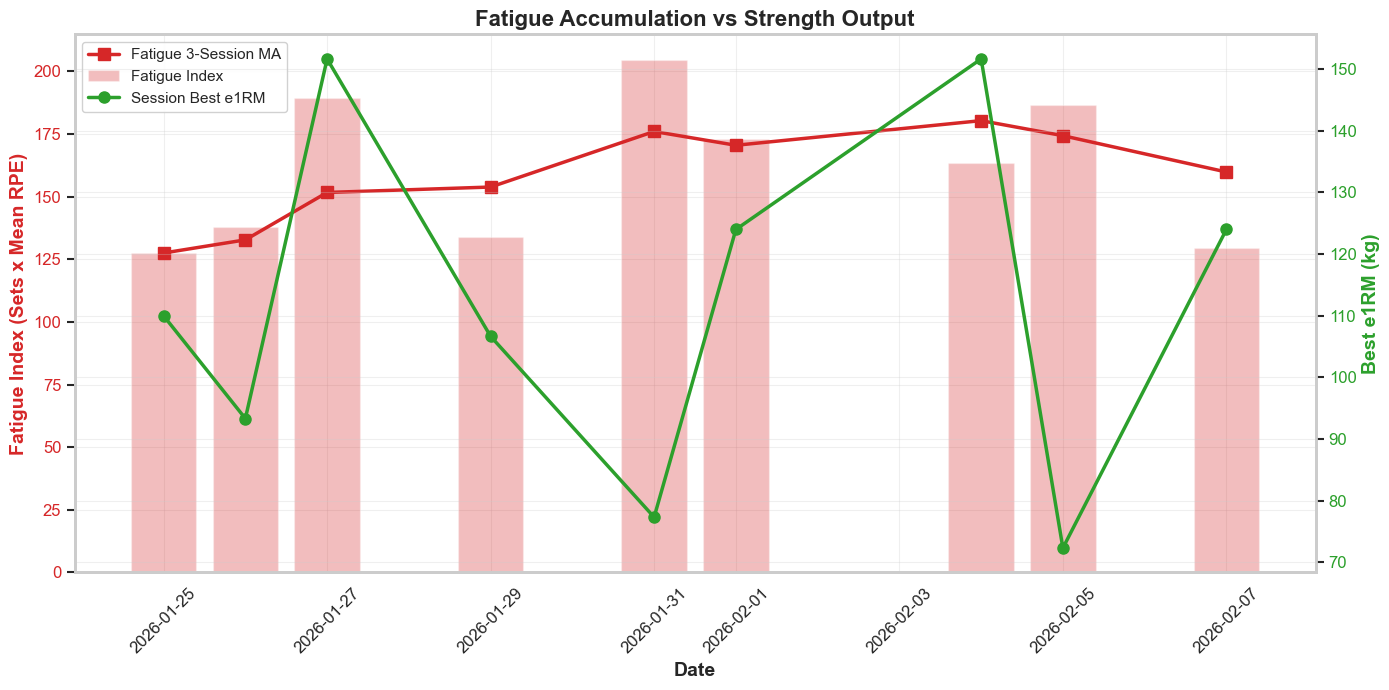

Fatigue is managed. Keep going.


In [49]:
# Fatigue index: total sets x mean RPE per session
fatigue_stats = df.groupby("Date").agg(
    set_count=("Movement", "count"),
    mean_rpe=("Intensity_RPE", "mean"),
    best_e1rm=("e1RM", "max")
).reset_index()

fatigue_stats["fatigue_index"] = fatigue_stats["set_count"] * fatigue_stats["mean_rpe"]
fatigue_stats["fatigue_ma3"] = fatigue_stats["fatigue_index"].rolling(window=3, min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(14, 7))

# Fatigue index on left axis
color_fatigue = "#d62728"
ax1.bar(fatigue_stats["Date"], fatigue_stats["fatigue_index"], alpha=0.3, color=color_fatigue, label="Fatigue Index")
ax1.plot(fatigue_stats["Date"], fatigue_stats["fatigue_ma3"], color=color_fatigue,
         linewidth=2.5, marker="s", markersize=8, label="Fatigue 3-Session MA")
ax1.set_xlabel("Date")
ax1.set_ylabel("Fatigue Index (Sets x Mean RPE)", color=color_fatigue)
ax1.tick_params(axis="y", labelcolor=color_fatigue)
ax1.tick_params(axis="x", rotation=45)

# Best e1RM on right axis
ax2 = ax1.twinx()
color_strength = "#2ca02c"
ax2.plot(fatigue_stats["Date"], fatigue_stats["best_e1rm"], color=color_strength,
         linewidth=2.5, marker="o", markersize=8, label="Session Best e1RM")
ax2.set_ylabel("Best e1RM (kg)", color=color_strength)
ax2.tick_params(axis="y", labelcolor=color_strength)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", framealpha=0.9)

ax1.set_title("Fatigue Accumulation vs Strength Output")
fig.tight_layout()
plt.show()

# Detect potential overreaching
if len(fatigue_stats) >= 3:
    recent_fatigue_trend = fatigue_stats["fatigue_ma3"].iloc[-1] - fatigue_stats["fatigue_ma3"].iloc[-3]
    recent_strength_trend = fatigue_stats["best_e1rm"].iloc[-1] - fatigue_stats["best_e1rm"].iloc[-3]
    if recent_fatigue_trend > 0 and recent_strength_trend <= 0:
        print("WARNING: Fatigue rising while strength is flat/dropping. Consider a deload.")
    elif recent_fatigue_trend > 0 and recent_strength_trend > 0:
        print("Fatigue rising but strength is still improving. Monitor closely.")
    else:
        print("Fatigue is managed. Keep going.")

## Recovery: RPE Drift Within Sessions

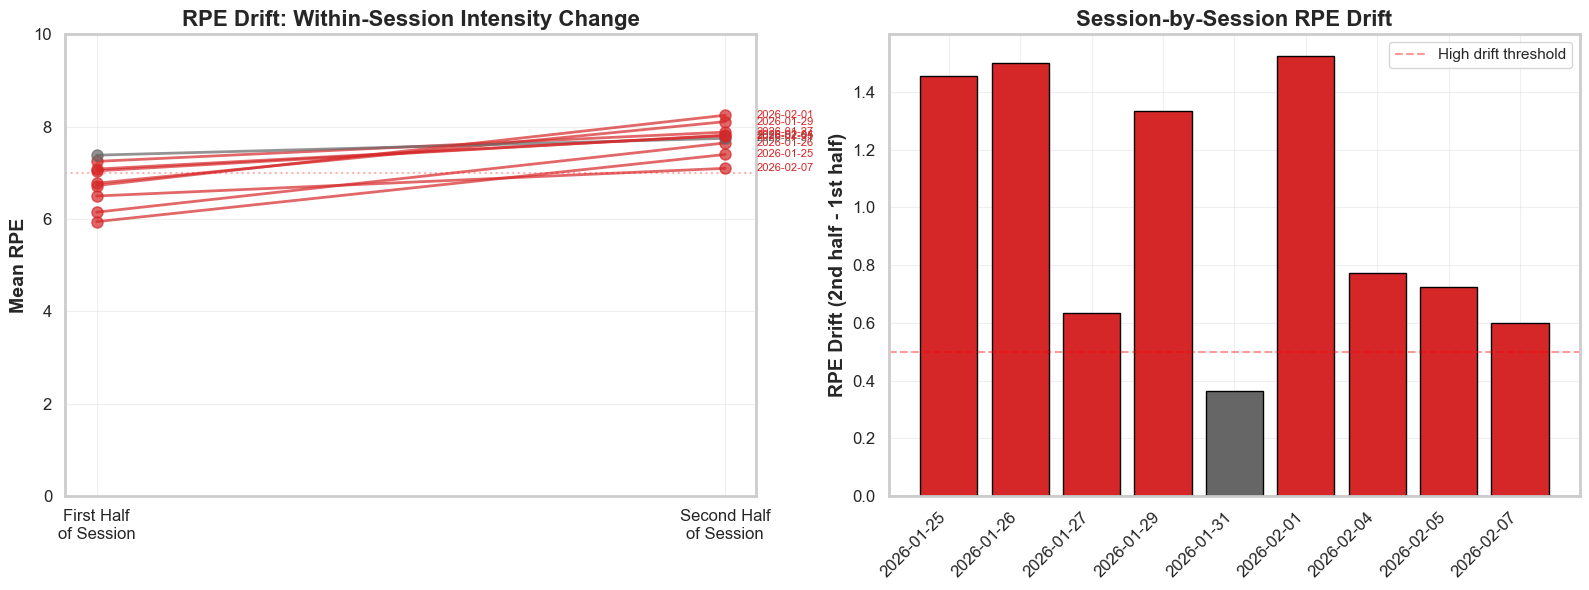


Average RPE drift: +0.99
Sessions tend to get harder. Consider reducing volume or adding more rest between sets.


In [50]:
# RPE drift: compare first half vs second half of each session
session_dates_sorted = sorted(df["Date"].unique())

drift_data = []
for date in session_dates_sorted:
    session = df[df["Date"] == date].reset_index(drop=True)
    n = len(session)
    if n < 4:
        continue
    mid = n // 2
    first_half_rpe = session.iloc[:mid]["Intensity_RPE"].mean()
    second_half_rpe = session.iloc[mid:]["Intensity_RPE"].mean()
    drift_data.append({
        "Date": date,
        "First Half": first_half_rpe,
        "Second Half": second_half_rpe,
        "Drift": second_half_rpe - first_half_rpe
    })

drift_df = pd.DataFrame(drift_data)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Slope chart: first half -> second half per session
x_pos = [0, 1]
for _, row in drift_df.iterrows():
    color = "#d62728" if row["Drift"] > 0.5 else ("#2ca02c" if row["Drift"] < -0.5 else "#666666")
    ax1.plot(x_pos, [row["First Half"], row["Second Half"]], marker="o", linewidth=2,
             color=color, alpha=0.7, markersize=8)
    ax1.text(1.05, row["Second Half"], str(row["Date"]), fontsize=8, va="center", color=color)

ax1.set_xticks(x_pos)
ax1.set_xticklabels(["First Half\nof Session", "Second Half\nof Session"], fontsize=12)
ax1.set_ylabel("Mean RPE")
ax1.set_title("RPE Drift: Within-Session Intensity Change")
ax1.set_ylim(0, 10)
ax1.axhline(y=7, color="red", linestyle=":", alpha=0.3)

# Bar chart of drift magnitude
colors = ["#d62728" if d > 0.5 else ("#2ca02c" if d < -0.5 else "#666666") for d in drift_df["Drift"]]
ax2.bar(range(len(drift_df)), drift_df["Drift"], color=colors, edgecolor="black", linewidth=1)
ax2.axhline(y=0, color="black", linewidth=1)
ax2.axhline(y=0.5, color="red", linestyle="--", alpha=0.4, label="High drift threshold")
ax2.set_xticks(range(len(drift_df)))
ax2.set_xticklabels([str(d) for d in drift_df["Date"]], rotation=45, ha="right")
ax2.set_ylabel("RPE Drift (2nd half - 1st half)")
ax2.set_title("Session-by-Session RPE Drift")
ax2.legend()

plt.tight_layout()
plt.show()

avg_drift = drift_df["Drift"].mean()
print(f"\nAverage RPE drift: {avg_drift:+.2f}")
if avg_drift > 0.5:
    print("Sessions tend to get harder. Consider reducing volume or adding more rest between sets.")
elif avg_drift < -0.5:
    print("Sessions get easier toward the end. You might be able to handle more volume.")
else:
    print("RPE is well-managed within sessions.")

## Recommended Next Session

In [51]:
def recommend_session(df):
    """Generate a recommended next session based on milestones, recency, and progression."""
    today = max(df["Date"])

    # --- Step 1: Score each compound family by priority ---
    # Map milestone search terms to families
    milestone_families = {
        "Squat": "Squat",
        "Deadlift": "Hinge",
        "Overhead Press": "Push (V)",
        "Bench Press": "Push (H)",
    }

    family_scores = {}
    family_milestone_gap = {}

    for search_term, family in milestone_families.items():
        # Get current best e1RM for this search term
        matches = df[df["Movement"].str.contains(search_term, case=False, na=False)]
        current_e1rm = matches["e1RM"].max() if not matches.empty else 0

        # Get closest milestone target e1RM
        if search_term in MILESTONES:
            target_e1rms = [w * (1 + r / 30) for w, r in MILESTONES[search_term]]
            closest_target = min(target_e1rms, key=lambda t: abs(t - current_e1rm))
            gap = max(0, (closest_target - current_e1rm) / closest_target) if closest_target > 0 else 0
        else:
            gap = 0.5

        # Days since family was last trained
        fam_dates = df[df["Family"] == family]["Date"]
        days_since = (today - fam_dates.max()).days if not fam_dates.empty else 14

        family_scores[family] = gap * max(days_since, 1)
        family_milestone_gap[family] = gap

    # --- Step 2: Select 1-2 main compound lifts ---
    sorted_families = sorted(family_scores, key=family_scores.get, reverse=True)
    primary_family = sorted_families[0]

    # Find antagonistic second compound
    secondary_family = None
    if primary_family in ANTAGONISTIC_PAIRS:
        candidate = ANTAGONISTIC_PAIRS[primary_family]
        median_score = np.median(list(family_scores.values()))
        if candidate in family_scores and family_scores[candidate] >= median_score * 0.5:
            secondary_family = candidate

    # --- Step 3: Pick specific movements and suggest weights ---
    recommendations = []

    for family in [primary_family] + ([secondary_family] if secondary_family else []):
        fam_df = df[df["Family"] == family]
        if fam_df.empty:
            continue

        # Pick the most frequently used movement in this family
        top_movement = fam_df["Movement"].value_counts().index[0]
        move_df = fam_df[fam_df["Movement"] == top_movement].sort_values("Timestamp")

        # Get last working sets (RPE >= 6, exclude warm-ups)
        working = move_df[move_df["Intensity_RPE"] >= 6]
        if working.empty:
            working = move_df

        last_weight = working.iloc[-1]["Load_kg"]
        last_reps = int(working.iloc[-1]["Reps"])

        # Check stall status for this movement pattern
        best_per_session = move_df.groupby("Date")["e1RM"].max()
        if len(best_per_session) > LOOKBACK_SESSIONS:
            delta = best_per_session.iloc[-1] - best_per_session.iloc[:-LOOKBACK_SESSIONS].max()
        else:
            delta = best_per_session.iloc[-1] - best_per_session.iloc[0] if len(best_per_session) > 1 else 1

        is_stalling = delta <= 1

        if is_stalling and last_reps <= 5:
            # Switch to moderate rep range
            work_weight = round(last_weight * 0.8 / 2.5) * 2.5
            work_reps = 5
            work_sets = 5
            rationale = "Stalling on heavy work -> volume block"
        elif is_stalling:
            # Switch to heavy work
            work_weight = round(last_weight * 1.1 / 2.5) * 2.5
            work_reps = 3
            work_sets = 5
            rationale = "Stalling on volume -> heavy block"
        else:
            # Progress: +2.5kg or +1 rep
            if last_reps >= 8:
                work_weight = last_weight + 2.5
                work_reps = last_reps
                work_sets = 3
                rationale = f"+2.5kg from last ({last_weight}kg x {last_reps})"
            else:
                work_weight = last_weight
                work_reps = last_reps + 1
                work_sets = 4
                rationale = f"+1 rep from last ({last_weight}kg x {last_reps})"

        # Warm-up ramp
        warmup_loads = [
            round(work_weight * 0.5 / 2.5) * 2.5,
            round(work_weight * 0.7 / 2.5) * 2.5,
        ]
        # Only include warm-ups if working weight is meaningful
        if work_weight > 20:
            for wl in warmup_loads:
                if wl >= 20:
                    recommendations.append({
                        "Movement": f"{top_movement} (warm-up)",
                        "Sets x Reps": f"1 x {max(5, work_reps)}",
                        "Load (kg)": f"{wl:.0f}",
                        "Rationale": "Ramp-up"
                    })

        recommendations.append({
            "Movement": f"{top_movement} (working)",
            "Sets x Reps": f"{work_sets} x {work_reps}",
            "Load (kg)": f"{work_weight:.1f}",
            "Rationale": rationale
        })

    # --- Step 4: Add accessories ---
    # Find under-represented families in recent sessions (last 3)
    recent_dates = sorted(df["Date"].unique())[-3:]
    recent_df = df[df["Date"].isin(recent_dates)]
    recent_family_counts = recent_df.groupby("Family").size()

    # Candidate accessory families (not the main compounds we already picked)
    used_families = {primary_family, secondary_family} if secondary_family else {primary_family}
    accessory_families = [f for f in MOVEMENT_PATTERNS if f not in used_families]

    # Sort by least recently trained
    accessory_families.sort(key=lambda f: recent_family_counts.get(f, 0))

    # Pick top 2 accessory families
    for family in accessory_families[:2]:
        fam_df = df[df["Family"] == family]
        if fam_df.empty:
            continue
        top_move = fam_df["Movement"].value_counts().index[0]
        last_load = fam_df[fam_df["Movement"] == top_move].iloc[-1]["Load_kg"]
        recommendations.append({
            "Movement": top_move,
            "Sets x Reps": "3 x 10",
            "Load (kg)": f"{last_load:.0f}",
            "Rationale": f"{family} accessory"
        })

    # Always include arm work
    arm_df = df[df["Family"] == "Arms"]
    if not arm_df.empty:
        arm_moves = arm_df["Movement"].value_counts().index[:2]
        for arm_move in arm_moves:
            last_arm = arm_df[arm_df["Movement"] == arm_move].iloc[-1]
            recommendations.append({
                "Movement": arm_move,
                "Sets x Reps": f"3 x {int(last_arm['Reps'])}",
                "Load (kg)": f"{last_arm['Load_kg']:.0f}",
                "Rationale": "Arms accessory"
            })

    # --- Step 5: Output ---
    focus_parts = [primary_family]
    if secondary_family:
        focus_parts.append(secondary_family)

    # Estimate tonnage
    est_tonnage = 0
    for r in recommendations:
        try:
            sets_reps = r["Sets x Reps"].split(" x ")
            s, rp = int(sets_reps[0]), int(sets_reps[1])
            load = float(r["Load (kg)"])
            est_tonnage += s * rp * load
        except (ValueError, IndexError):
            pass

    print("=" * 70)
    print(f"  RECOMMENDED NEXT SESSION")
    print(f"  Focus: {' + '.join(focus_parts)}")
    print("=" * 70)
    print(f"\n{'Movement':<30} {'Sets x Reps':<14} {'Load (kg)':<12} {'Rationale'}")
    print("-" * 70)
    for r in recommendations:
        print(f"{r['Movement']:<30} {r['Sets x Reps']:<14} {r['Load (kg)']:<12} {r['Rationale']}")
    print("-" * 70)
    print(f"\nEstimated session tonnage: ~{est_tonnage:,.0f} kg")

    # Priority reasoning
    print(f"\n--- Priority Reasoning ---")
    for family in sorted_families:
        gap_pct = family_milestone_gap.get(family, 0) * 100
        fam_dates = df[df["Family"] == family]["Date"]
        days = (today - fam_dates.max()).days if not fam_dates.empty else 99
        print(f"  {family:<10} score={family_scores[family]:.2f}  (gap={gap_pct:.0f}%, {days}d since last)")

recommend_session(df)

  RECOMMENDED NEXT SESSION
  Focus: Hinge

Movement                       Sets x Reps    Load (kg)    Rationale
----------------------------------------------------------------------
Deadlift (warm-up)             1 x 5          52           Ramp-up
Deadlift (warm-up)             1 x 5          72           Ramp-up
Deadlift (working)             5 x 5          105.0        Stalling on heavy work -> volume block
Assisted Pullup                3 x 10         58           Pull (V) accessory
Overhead Press                 3 x 10         30           Push (V) accessory
Bicep Curl                     3 x 15         25           Arms accessory
Bicep Curls                    3 x 8          25           Arms accessory
----------------------------------------------------------------------

Estimated session tonnage: ~7,610 kg

--- Priority Reasoning ---
  Hinge      score=0.56  (gap=19%, 3d since last)
  Push (V)   score=0.32  (gap=11%, 3d since last)
  Squat      score=0.25  (gap=25%, 0d since 